In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

path = "../input/histopathologic-cancer-detection/"

data = pd.read_csv(path +"train_labels.csv")
train_path = path +'train/'
test_path = path + 'test/'
# quick look at the label stats
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [2]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

visualisation from : https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai

Text(0, 0.5, 'Tumor tissue samples')

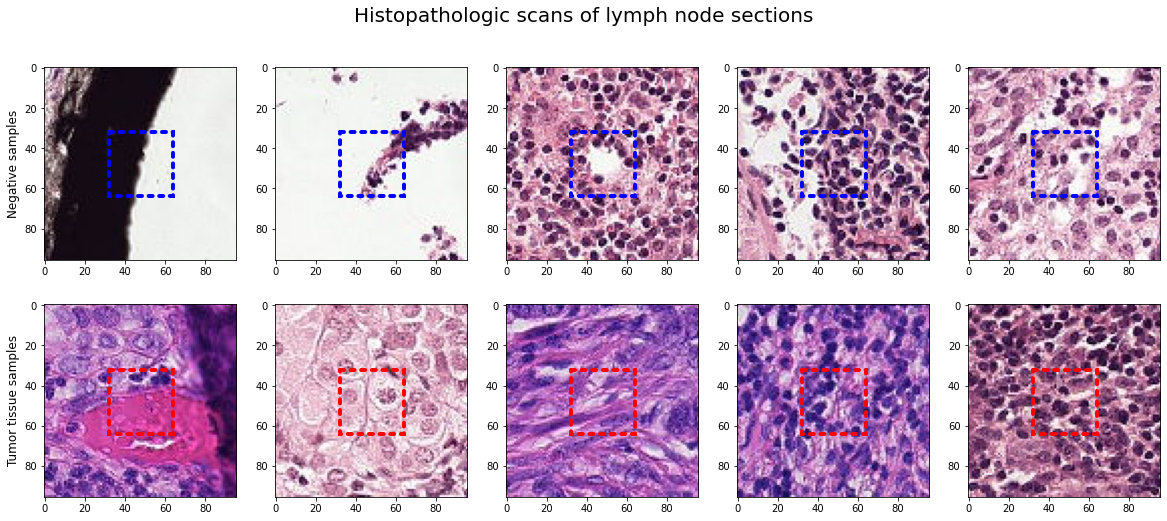

In [3]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [4]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.0 requires fastcore>=1.0.15, but you'll have fastcore 1.0.13 which is incompatible.


In [6]:
path = "../input/histopathologic-cancer-detection/"


In [7]:
def get_x(r): return path+'train/'+r['id']+'.tif'
def get_y(r): return r['label']


# start with creatinga datablock

dblock =  DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.2,seed=42), 
                    get_x=get_x, 
                    get_y=get_y, 
                    item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(data)



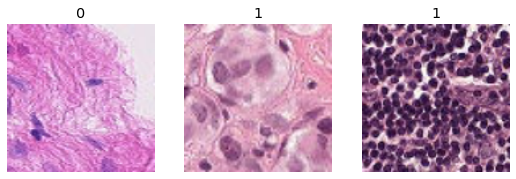

In [8]:
dls.show_batch(nrows=1, ncols=3)

So we are able to create a dataloader however the images are too big right nowm we need a way to reduce the size of images. lets try for a crop to 48x48 at center with flip. and brightness. https://docs.fast.ai/vision.augment#PadMode

In [10]:
dblock =  DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.2,seed=42), 
                    get_x=get_x, 
                    get_y=get_y, 
                    item_tfms= (CropPad(48, pad_mode='zeros'),DihedralItem(p=1.0, nm=None, before_call=None) ))
dls = dblock.dataloaders(data)

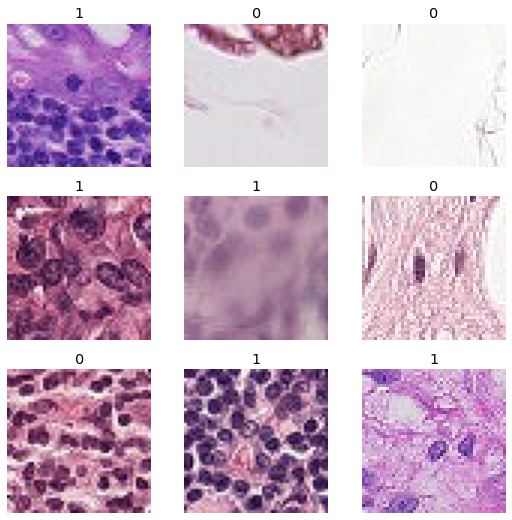

In [11]:
dls.show_batch()

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.414943,0.383958,0.164799,10:29


epoch,train_loss,valid_loss,error_rate,time
0,0.328589,0.309405,0.130076,08:55
1,0.288202,0.266488,0.108942,08:49
2,0.255233,0.246442,0.099511,08:57
3,0.233838,0.239476,0.096853,09:55


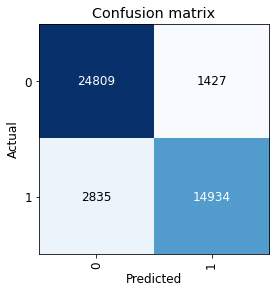

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

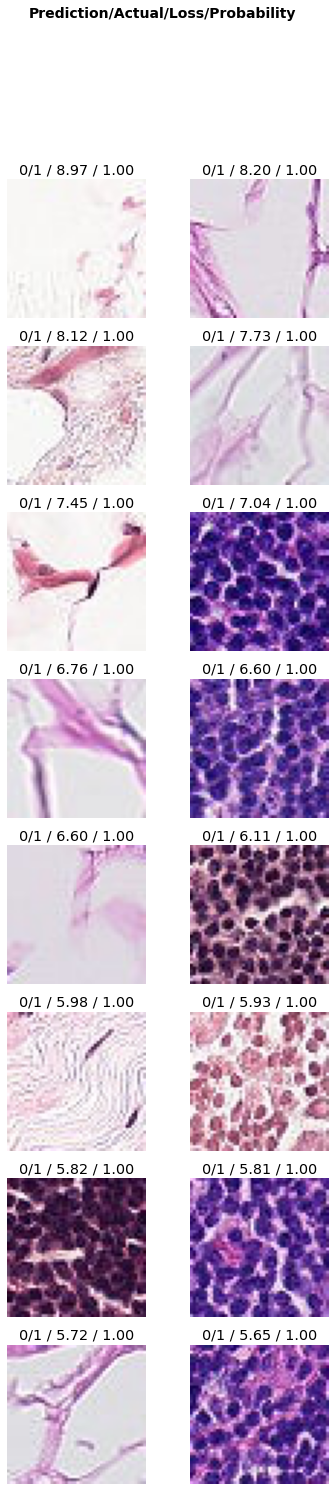

In [15]:
interp.plot_top_losses(16, nrows=8)

In [16]:
learn.predict('../input/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif')

('1', tensor(1), tensor([0.0078, 0.9922]))

### Problems with testing data

for submission again from : https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai. Maybe U sould consider differnet way to evaluate any ideas ?

In [ ]:
path = "../input/histopathologic-cancer-detection/"

from : https://www.kaggle.com/mamamot/fastai-v2-example and https://www.kaggle.com/mentalwanderer/image-classification-workflow-with-fast-ai

for more info on tta
https://docs.fast.ai/learner#Learner.tta

In [89]:
preds, y = learn.tta()
acc = accuracy(preds, y)


In [22]:
from sklearn.metrics import roc_auc_score
def auc_score(y_pred,y_true,tens=True):
    score = roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score = tensor(score)
    return score

In [23]:
print('The validation accuracy is {} %.'.format(acc * 100))
pred_score = auc_score(preds,y).item()
print('The validation AUC is {}.'.format(pred_score))

The validation accuracy is 91.07373809814453 %.
The validation AUC is 0.9663984179496765.


Since definition of tta has changed I am unable currently to make it work, however creating a dataloader for test data

In [41]:
# # doesnt work
# tf_fns = get_image_files(path + 'test')
# test_data = DataBlock(get_items=get_image_files,
#                  item_tfms=(CropPad(48, pad_mode='zeros'),DihedralItem(p=1.0, nm=None, before_call=None)))
# dl_test = test_data.dataloaders(path+'test')
# dl_test.show_batch()


In [49]:

test_images = get_image_files(path + 'test')
preds,y = learn.get_preds(dl=dls.test_dl(test_images, shuffle=False, drop_last=False))

In [73]:
pred_list = list(preds[:,1])

tensor(0.1133)
tensor(0.1209)
tensor(0.8817)
tensor(0.9557)
tensor(0.9043)
tensor(0.0051)
tensor(0.8918)
tensor(0.9841)
tensor(0.9966)
tensor(0.9913)
tensor(0.9494)
tensor(0.5795)
tensor(0.9990)
tensor(0.9926)
tensor(0.9460)
tensor(0.7220)
tensor(0.9830)
tensor(0.5146)
tensor(0.9785)
tensor(0.9473)
tensor(0.9605)
tensor(0.9710)
tensor(0.9584)
tensor(0.9970)
tensor(0.9827)
tensor(0.0722)
tensor(0.9708)
tensor(0.9677)
tensor(0.9949)
tensor(0.0250)
tensor(0.0149)
tensor(0.0390)
tensor(0.9827)
tensor(0.9432)
tensor(0.9884)
tensor(0.3924)
tensor(0.9462)
tensor(0.0375)
tensor(0.0211)
tensor(0.9991)
tensor(0.7248)
tensor(0.0022)
tensor(0.1629)
tensor(0.7939)
tensor(0.9887)
tensor(0.8700)
tensor(0.9896)
tensor(0.9988)
tensor(0.8923)
tensor(0.0037)
tensor(0.0599)
tensor(2.6732e-05)
tensor(0.9972)
tensor(0.1196)
tensor(0.0654)
tensor(0.4011)
tensor(0.0214)
tensor(0.8493)
tensor(0.5582)
tensor(0.9206)
tensor(0.9724)
tensor(0.9418)
tensor(0.9847)
tensor(0.9374)
tensor(0.5910)
tensor(0.0093)
tensor

tensor(0.7178)
tensor(0.2169)
tensor(0.9716)
tensor(0.0286)
tensor(0.0006)
tensor(0.1184)
tensor(0.2527)
tensor(0.7959)
tensor(0.8673)
tensor(0.9446)
tensor(0.9779)
tensor(0.9966)
tensor(0.9019)
tensor(0.0073)
tensor(0.9933)
tensor(0.8557)
tensor(0.2453)
tensor(0.8218)
tensor(0.1560)
tensor(0.9914)
tensor(0.9723)
tensor(0.7618)
tensor(0.0147)
tensor(0.9621)
tensor(0.9884)
tensor(0.5223)
tensor(0.6294)
tensor(0.8920)
tensor(0.0345)
tensor(0.9998)
tensor(0.7710)
tensor(0.8416)
tensor(0.0628)
tensor(0.1040)
tensor(0.9819)
tensor(0.9424)
tensor(0.0686)
tensor(0.3817)
tensor(0.9996)
tensor(0.9566)
tensor(0.2592)
tensor(0.3663)
tensor(0.9902)
tensor(0.8839)
tensor(0.9711)
tensor(0.8755)
tensor(0.5807)
tensor(0.9962)
tensor(0.8733)
tensor(0.1089)
tensor(0.8173)
tensor(0.9709)
tensor(0.2954)
tensor(0.7626)
tensor(0.9249)
tensor(0.9178)
tensor(0.8525)
tensor(0.0002)
tensor(0.9961)
tensor(0.0711)
tensor(0.6813)
tensor(0.6379)
tensor(0.0088)
tensor(0.9215)
tensor(0.4197)
tensor(0.6881)
tensor(0.9

tensor(0.9845)
tensor(0.9614)
tensor(0.0249)
tensor(0.1208)
tensor(0.9943)
tensor(0.9184)
tensor(0.0003)
tensor(0.4796)
tensor(0.2098)
tensor(0.9897)
tensor(0.1726)
tensor(0.1263)
tensor(0.9715)
tensor(0.5098)
tensor(0.0027)
tensor(0.9471)
tensor(0.9973)
tensor(0.2225)
tensor(0.0402)
tensor(0.0097)
tensor(0.9396)
tensor(0.9750)
tensor(0.0695)
tensor(0.9853)
tensor(0.9997)
tensor(0.9061)
tensor(0.9967)
tensor(0.9005)
tensor(0.9041)
tensor(0.0414)
tensor(0.9906)
tensor(0.9553)
tensor(0.9382)
tensor(0.7844)
tensor(0.0273)
tensor(0.8434)
tensor(0.9466)
tensor(0.0321)
tensor(0.9992)
tensor(0.9083)
tensor(0.9999)
tensor(0.3388)
tensor(0.0421)
tensor(0.4858)
tensor(0.2211)
tensor(0.9999)
tensor(0.8733)
tensor(0.5145)
tensor(0.5911)
tensor(0.5644)
tensor(0.9944)
tensor(0.0138)
tensor(0.9896)
tensor(0.9423)
tensor(0.9344)
tensor(0.9757)
tensor(0.0385)
tensor(0.9107)
tensor(0.7029)
tensor(0.2600)
tensor(0.0116)
tensor(0.6310)
tensor(0.7670)
tensor(0.9661)
tensor(0.9984)
tensor(0.5536)
tensor(0.4

tensor(1.)
tensor(0.8555)
tensor(0.4729)
tensor(0.8878)
tensor(0.1159)
tensor(0.7397)
tensor(0.9900)
tensor(0.9312)
tensor(0.8694)
tensor(0.9989)
tensor(0.7378)
tensor(0.0212)
tensor(0.0079)
tensor(0.9992)
tensor(0.9957)
tensor(0.9382)
tensor(0.7310)
tensor(0.9926)
tensor(0.4037)
tensor(0.7671)
tensor(0.9997)
tensor(0.2547)
tensor(0.8809)
tensor(0.7238)
tensor(0.3853)
tensor(0.9993)
tensor(0.9789)
tensor(0.9936)
tensor(0.0175)
tensor(0.0043)
tensor(0.9028)
tensor(0.9995)
tensor(0.9979)
tensor(0.6318)
tensor(0.1407)
tensor(0.9923)
tensor(0.0128)
tensor(0.9596)
tensor(0.7432)
tensor(0.0767)
tensor(0.1641)
tensor(0.8802)
tensor(0.2386)
tensor(0.9907)
tensor(0.9977)
tensor(0.9438)
tensor(0.9704)
tensor(0.9727)
tensor(0.9605)
tensor(0.8122)
tensor(0.8574)
tensor(0.9973)
tensor(0.9891)
tensor(0.6746)
tensor(0.7754)
tensor(0.6328)
tensor(0.9909)
tensor(0.3626)
tensor(0.9572)
tensor(0.9618)
tensor(0.9593)
tensor(0.6669)
tensor(0.9482)
tensor(0.9778)
tensor(0.4275)
tensor(0.0013)
tensor(0.9844)

tensor(0.9919)
tensor(0.9474)
tensor(0.5815)
tensor(0.9259)
tensor(0.9395)
tensor(0.9997)
tensor(0.9950)
tensor(0.7015)
tensor(0.0189)
tensor(0.2692)
tensor(0.6517)
tensor(0.9998)
tensor(0.9938)
tensor(0.3702)
tensor(0.9206)
tensor(0.7054)
tensor(0.8697)
tensor(0.9930)
tensor(0.8449)
tensor(0.0010)
tensor(0.8187)
tensor(0.9603)
tensor(0.9564)
tensor(0.9774)
tensor(0.0095)
tensor(0.9997)
tensor(0.9949)
tensor(0.6172)
tensor(0.0813)
tensor(0.9917)
tensor(0.5557)
tensor(0.8730)
tensor(0.9438)
tensor(6.4983e-10)
tensor(0.9773)
tensor(0.1097)
tensor(0.9896)
tensor(0.0417)
tensor(0.1110)
tensor(0.1194)
tensor(0.2583)
tensor(0.9703)
tensor(0.8327)
tensor(0.6992)
tensor(0.9058)
tensor(0.9449)
tensor(0.1572)
tensor(0.0840)
tensor(0.0047)
tensor(0.9869)
tensor(0.9858)
tensor(0.0003)
tensor(0.0576)
tensor(0.9321)
tensor(0.8659)
tensor(0.9560)
tensor(0.9869)
tensor(0.9745)
tensor(0.1157)
tensor(0.9694)
tensor(0.9488)
tensor(0.9902)
tensor(0.9157)
tensor(0.5135)
tensor(0.5010)
tensor(0.4955)
tensor

tensor(0.7583)
tensor(0.9576)
tensor(0.9008)
tensor(0.8283)
tensor(0.2662)
tensor(0.9964)
tensor(0.8719)
tensor(0.0054)
tensor(0.3590)
tensor(0.9886)
tensor(0.1572)
tensor(0.2582)
tensor(0.8795)
tensor(0.4606)
tensor(0.9262)
tensor(0.9240)
tensor(0.9987)
tensor(0.7220)
tensor(0.0082)
tensor(0.9980)
tensor(0.9471)
tensor(0.2881)
tensor(0.9712)
tensor(0.7288)
tensor(0.1731)
tensor(0.0049)
tensor(0.9746)
tensor(0.4053)
tensor(0.6281)
tensor(0.6002)
tensor(0.1972)
tensor(0.9693)
tensor(0.9843)
tensor(0.9982)
tensor(0.3845)
tensor(0.0579)
tensor(0.2427)
tensor(0.9083)
tensor(0.9596)
tensor(0.9895)
tensor(0.8791)
tensor(0.9660)
tensor(0.9420)
tensor(0.5425)
tensor(0.6525)
tensor(0.9870)
tensor(0.9622)
tensor(0.9537)
tensor(0.0667)
tensor(0.9422)
tensor(0.9824)
tensor(0.7373)
tensor(0.9812)
tensor(0.0086)
tensor(0.9039)
tensor(1.0000)
tensor(0.9235)
tensor(0.8119)
tensor(0.0265)
tensor(0.6431)
tensor(0.9998)
tensor(0.9813)
tensor(0.9994)
tensor(0.9545)
tensor(0.2280)
tensor(0.0014)
tensor(0.9

tensor(0.9914)
tensor(0.8417)
tensor(0.2780)
tensor(0.9802)
tensor(1.0000)
tensor(0.0105)
tensor(0.7519)
tensor(0.6932)
tensor(0.9845)
tensor(0.9923)
tensor(2.9263e-05)
tensor(0.0981)
tensor(0.0520)
tensor(0.9238)
tensor(0.1970)
tensor(0.7080)
tensor(0.9935)
tensor(0.1866)
tensor(0.9391)
tensor(0.6894)
tensor(0.9901)
tensor(0.7491)
tensor(0.8211)
tensor(0.1415)
tensor(0.9249)
tensor(0.0533)
tensor(0.9550)
tensor(0.3578)
tensor(0.9046)
tensor(0.9762)
tensor(0.9969)
tensor(0.9888)
tensor(0.9913)
tensor(0.0003)
tensor(0.9947)
tensor(0.4690)
tensor(1.0000)
tensor(0.3627)
tensor(0.3545)
tensor(0.9982)
tensor(0.3972)
tensor(0.9977)
tensor(0.9304)
tensor(0.5388)
tensor(0.0687)
tensor(0.2328)
tensor(1.0000)
tensor(0.0199)
tensor(0.0030)
tensor(0.2380)
tensor(0.8891)
tensor(0.9797)
tensor(0.1430)
tensor(0.0131)
tensor(0.0339)
tensor(0.9784)
tensor(1.0000)
tensor(0.9945)
tensor(0.9508)
tensor(0.1685)
tensor(0.6963)
tensor(0.0344)
tensor(0.4065)
tensor(0.9908)
tensor(0.5636)
tensor(0.7985)
tensor

tensor(0.0361)
tensor(0.9994)
tensor(0.9912)
tensor(0.9758)
tensor(0.9852)
tensor(0.2049)
tensor(0.3034)
tensor(0.6346)
tensor(0.5376)
tensor(0.9871)
tensor(0.7135)
tensor(0.7677)
tensor(0.4107)
tensor(0.9185)
tensor(0.0099)
tensor(0.9461)
tensor(0.0048)
tensor(0.9686)
tensor(0.8145)
tensor(0.8567)
tensor(0.9842)
tensor(0.9999)
tensor(0.0024)
tensor(0.9018)
tensor(0.0051)
tensor(0.9832)
tensor(0.9665)
tensor(0.9999)
tensor(0.1149)
tensor(0.8726)
tensor(9.0615e-06)
tensor(0.0071)
tensor(0.0301)
tensor(0.1434)
tensor(0.0684)
tensor(0.9559)
tensor(0.0024)
tensor(0.0383)
tensor(0.8930)
tensor(0.8991)
tensor(0.9491)
tensor(0.0023)
tensor(0.6934)
tensor(0.1333)
tensor(0.9206)
tensor(0.0580)
tensor(0.9980)
tensor(0.0418)
tensor(0.8704)
tensor(0.9877)
tensor(0.1699)
tensor(0.9975)
tensor(0.1480)
tensor(0.9803)
tensor(0.9400)
tensor(0.9803)
tensor(0.5574)
tensor(0.7965)
tensor(0.9903)
tensor(0.0844)
tensor(0.9861)
tensor(0.0154)
tensor(0.9988)
tensor(0.9223)
tensor(0.9998)
tensor(0.8591)
tensor

tensor(0.6016)
tensor(0.5014)
tensor(0.9179)
tensor(0.9993)
tensor(0.9889)
tensor(0.2602)
tensor(0.9797)
tensor(0.4841)
tensor(0.9782)
tensor(0.0043)
tensor(0.0633)
tensor(0.8313)
tensor(0.8809)
tensor(0.0247)
tensor(0.2950)
tensor(0.7252)
tensor(0.0272)
tensor(0.9725)
tensor(0.0015)
tensor(0.0867)
tensor(0.1108)
tensor(5.5339e-08)
tensor(0.4893)
tensor(0.7508)
tensor(0.2339)
tensor(0.9783)
tensor(0.0607)
tensor(0.2971)
tensor(0.8219)
tensor(1.0000)
tensor(0.7581)
tensor(0.9366)
tensor(0.9655)
tensor(0.0062)
tensor(0.9809)
tensor(0.9813)
tensor(0.0349)
tensor(0.4129)
tensor(0.9834)
tensor(0.0233)
tensor(0.9946)
tensor(0.9971)
tensor(0.9797)
tensor(0.4777)
tensor(0.5952)
tensor(0.1240)
tensor(0.9445)
tensor(0.9204)
tensor(0.1595)
tensor(0.9893)
tensor(0.0312)
tensor(0.9354)
tensor(0.7694)
tensor(0.6694)
tensor(0.9780)
tensor(0.9538)
tensor(0.9530)
tensor(0.6356)
tensor(0.8338)
tensor(0.5303)
tensor(0.9671)
tensor(0.9911)
tensor(0.9921)
tensor(0.8733)
tensor(0.9819)
tensor(0.0085)
tensor

tensor(0.9971)
tensor(0.7792)
tensor(0.0342)
tensor(0.9593)
tensor(0.0333)
tensor(0.0553)
tensor(0.9544)
tensor(0.9746)
tensor(0.9980)
tensor(0.6731)
tensor(0.9603)
tensor(0.9506)
tensor(0.2550)
tensor(0.1009)
tensor(0.8468)
tensor(0.8689)
tensor(0.9631)
tensor(0.9595)
tensor(0.3978)
tensor(0.9854)
tensor(0.8263)
tensor(1.0000)
tensor(0.9933)
tensor(0.5405)
tensor(0.4770)
tensor(0.7892)
tensor(0.9954)
tensor(0.0781)
tensor(0.0111)
tensor(0.4930)
tensor(0.9979)
tensor(0.9998)
tensor(0.9525)
tensor(0.9867)
tensor(0.0177)
tensor(0.9996)
tensor(0.0572)
tensor(0.1978)
tensor(0.4102)
tensor(0.0621)
tensor(0.9204)
tensor(0.0028)
tensor(0.9803)
tensor(0.9080)
tensor(0.2016)
tensor(0.9393)
tensor(0.0896)
tensor(0.9568)
tensor(0.4833)
tensor(0.9397)
tensor(0.9839)
tensor(0.4856)
tensor(0.4182)
tensor(0.9845)
tensor(0.2645)
tensor(0.3951)
tensor(0.7544)
tensor(0.9845)
tensor(0.4310)
tensor(0.9821)
tensor(0.8334)
tensor(1.2149e-05)
tensor(0.9944)
tensor(0.9883)
tensor(0.9519)
tensor(0.0472)
tensor

tensor(0.1258)
tensor(0.5206)
tensor(0.1701)
tensor(0.6167)
tensor(0.0991)
tensor(0.9968)
tensor(0.1200)
tensor(1.0000)
tensor(0.9997)
tensor(1.0000)
tensor(0.8198)
tensor(0.2776)
tensor(0.7157)
tensor(0.6160)
tensor(0.3502)
tensor(0.0109)
tensor(1.)
tensor(0.9983)
tensor(0.9700)
tensor(0.9564)
tensor(0.3966)
tensor(0.9830)
tensor(0.9937)
tensor(0.8940)
tensor(0.7243)
tensor(0.2631)
tensor(0.9973)
tensor(0.9998)
tensor(0.7388)
tensor(0.2654)
tensor(0.9979)
tensor(0.0421)
tensor(0.7354)
tensor(0.9967)
tensor(0.9491)
tensor(0.0731)
tensor(0.3250)
tensor(0.9409)
tensor(0.7949)
tensor(0.9625)
tensor(0.0216)
tensor(0.9850)
tensor(0.9918)
tensor(0.3455)
tensor(0.4031)
tensor(0.0621)
tensor(0.9142)
tensor(0.9391)
tensor(0.9404)
tensor(0.9944)
tensor(0.9289)
tensor(0.9955)
tensor(0.1668)
tensor(0.7148)
tensor(0.5734)
tensor(0.9569)
tensor(0.9598)
tensor(0.7100)
tensor(0.9627)
tensor(0.0735)
tensor(0.9493)
tensor(0.6382)
tensor(0.9921)
tensor(0.2487)
tensor(0.0771)
tensor(0.9475)
tensor(0.1693)

tensor(0.9989)
tensor(0.9984)
tensor(0.5234)
tensor(0.9784)
tensor(0.9275)
tensor(0.8517)
tensor(0.8218)
tensor(0.9999)
tensor(0.7196)
tensor(0.2030)
tensor(0.9922)
tensor(0.9625)
tensor(0.8289)
tensor(0.0019)
tensor(0.0933)
tensor(0.9995)
tensor(0.5875)
tensor(0.9987)
tensor(1.0000)
tensor(0.9975)
tensor(0.7831)
tensor(0.9956)
tensor(0.9606)
tensor(0.7976)
tensor(0.8823)
tensor(0.8988)
tensor(0.9617)
tensor(0.9965)
tensor(0.7079)
tensor(0.9960)
tensor(0.0131)
tensor(6.6507e-10)
tensor(0.0003)
tensor(0.9814)
tensor(0.2606)
tensor(0.9278)
tensor(0.4212)
tensor(0.9879)
tensor(0.9306)
tensor(0.9004)
tensor(0.9998)
tensor(0.9386)
tensor(0.8829)
tensor(0.4411)
tensor(0.9758)
tensor(0.4182)
tensor(0.9068)
tensor(0.9545)
tensor(0.7421)
tensor(0.9977)
tensor(0.0503)
tensor(0.0201)
tensor(0.8035)
tensor(0.1452)
tensor(0.9403)
tensor(0.9850)
tensor(0.9694)
tensor(0.9516)
tensor(0.9963)
tensor(0.9991)
tensor(0.0221)
tensor(0.9177)
tensor(0.9488)
tensor(0.9370)
tensor(0.9170)
tensor(0.7340)
tensor

tensor(0.0650)
tensor(0.9860)
tensor(0.3158)
tensor(0.9907)
tensor(0.9923)
tensor(0.9647)
tensor(0.8990)
tensor(0.8245)
tensor(0.1818)
tensor(0.7016)
tensor(0.8169)
tensor(0.9878)
tensor(0.9993)
tensor(0.9295)
tensor(0.8900)
tensor(0.9859)
tensor(0.0075)
tensor(0.7553)
tensor(0.0255)
tensor(0.0226)
tensor(0.8899)
tensor(0.0122)
tensor(0.9502)
tensor(0.9549)
tensor(0.9816)
tensor(0.9659)
tensor(0.4171)
tensor(2.5606e-09)
tensor(0.9911)
tensor(0.2122)
tensor(0.5329)
tensor(0.0332)
tensor(0.9841)
tensor(0.7871)
tensor(0.1317)
tensor(0.9003)
tensor(0.9825)
tensor(0.6747)
tensor(0.0101)
tensor(0.0066)
tensor(0.9767)
tensor(0.9740)
tensor(0.1779)
tensor(0.0075)
tensor(0.4046)
tensor(0.9896)
tensor(1.5229e-08)
tensor(0.9726)
tensor(0.1919)
tensor(1.4803e-06)
tensor(0.9693)
tensor(0.0476)
tensor(0.9958)
tensor(0.0062)
tensor(0.9981)
tensor(0.8506)
tensor(0.9972)
tensor(0.0624)
tensor(0.9932)
tensor(0.9641)
tensor(0.7690)
tensor(0.7988)
tensor(0.9963)
tensor(0.9277)
tensor(0.6826)
tensor(0.8426

tensor(0.9614)
tensor(0.9528)
tensor(0.9967)
tensor(0.6232)
tensor(0.5417)
tensor(0.7965)
tensor(0.9990)
tensor(0.0005)
tensor(0.6068)
tensor(0.9919)
tensor(0.9871)
tensor(0.9180)
tensor(0.0741)
tensor(0.8820)
tensor(0.0072)
tensor(0.8582)
tensor(0.9169)
tensor(0.2105)
tensor(0.0478)
tensor(0.9807)
tensor(0.5770)
tensor(0.9850)
tensor(0.1274)
tensor(0.8470)
tensor(0.1607)
tensor(0.8268)
tensor(0.7244)
tensor(0.0174)
tensor(0.1484)
tensor(0.9704)
tensor(0.7691)
tensor(0.0325)
tensor(0.7582)
tensor(0.7431)
tensor(0.9010)
tensor(0.9881)
tensor(0.9351)
tensor(0.9932)
tensor(0.0563)
tensor(0.9857)
tensor(0.9449)
tensor(0.9593)
tensor(0.5683)
tensor(0.9984)
tensor(0.0740)
tensor(0.9657)
tensor(0.8681)
tensor(0.9744)
tensor(0.9627)
tensor(0.2483)
tensor(0.3048)
tensor(0.9462)
tensor(0.9291)
tensor(0.9960)
tensor(0.0008)
tensor(0.9173)
tensor(0.9865)
tensor(0.9278)
tensor(0.9696)
tensor(0.9150)
tensor(0.1991)
tensor(1.0000)
tensor(0.9797)
tensor(0.7565)
tensor(0.1692)
tensor(0.9544)
tensor(0.0

tensor(0.0452)
tensor(0.8275)
tensor(0.0901)
tensor(0.1154)
tensor(0.8990)
tensor(0.0582)
tensor(0.9756)
tensor(0.7399)
tensor(0.0237)
tensor(0.8923)
tensor(0.9795)
tensor(0.9807)
tensor(0.9569)
tensor(0.9220)
tensor(0.8353)
tensor(0.0011)
tensor(0.9420)
tensor(0.9864)
tensor(0.0340)
tensor(0.9954)
tensor(0.9561)
tensor(0.9583)
tensor(0.9936)
tensor(0.0001)
tensor(0.7744)
tensor(0.9222)
tensor(1.0000)
tensor(0.0459)
tensor(0.6221)
tensor(0.8578)
tensor(0.8819)
tensor(0.2611)
tensor(0.8657)
tensor(0.9911)
tensor(0.7888)
tensor(0.9801)
tensor(0.8236)
tensor(0.5625)
tensor(0.1820)
tensor(0.9961)
tensor(0.9993)
tensor(0.1108)
tensor(0.0019)
tensor(0.8961)
tensor(0.5777)
tensor(0.5762)
tensor(0.9875)
tensor(0.9889)
tensor(0.9187)
tensor(0.8117)
tensor(0.0054)
tensor(0.9923)
tensor(0.9846)
tensor(0.7778)
tensor(5.7021e-05)
tensor(0.9805)
tensor(0.2984)
tensor(0.9384)
tensor(0.5152)
tensor(0.5614)
tensor(0.9997)
tensor(0.7726)
tensor(0.4231)
tensor(0.0120)
tensor(0.2099)
tensor(0.9723)
tensor

tensor(0.7604)
tensor(0.0006)
tensor(0.9470)
tensor(0.9993)
tensor(0.3522)
tensor(0.9884)
tensor(0.3680)
tensor(0.9025)
tensor(0.0369)
tensor(0.9449)
tensor(0.8433)
tensor(0.9950)
tensor(0.9678)
tensor(0.8796)
tensor(0.9399)
tensor(0.9991)
tensor(0.8097)
tensor(0.0612)
tensor(0.9523)
tensor(0.7304)
tensor(0.0872)
tensor(0.9911)
tensor(0.9996)
tensor(0.7375)
tensor(0.0457)
tensor(0.9941)
tensor(0.9732)
tensor(0.9005)
tensor(0.4399)
tensor(0.9626)
tensor(0.5340)
tensor(0.9874)
tensor(0.1479)
tensor(0.6735)
tensor(0.9969)
tensor(0.9677)
tensor(0.1545)
tensor(0.9844)
tensor(0.9940)
tensor(0.0820)
tensor(0.9054)
tensor(0.7017)
tensor(0.0384)
tensor(0.9433)
tensor(0.9664)
tensor(0.0194)
tensor(0.9236)
tensor(0.9940)
tensor(0.9297)
tensor(0.9880)
tensor(0.7365)
tensor(0.0070)
tensor(0.9018)
tensor(0.6594)
tensor(0.9498)
tensor(0.4653)
tensor(0.9789)
tensor(0.7172)
tensor(0.9990)
tensor(0.3335)
tensor(0.8490)
tensor(0.9506)
tensor(0.9551)
tensor(0.9827)
tensor(0.2576)
tensor(0.8496)
tensor(0.0

tensor(1.0000)
tensor(0.9858)
tensor(0.6662)
tensor(0.6397)
tensor(0.0596)
tensor(0.6683)
tensor(0.9933)
tensor(0.9769)
tensor(0.4990)
tensor(0.2830)
tensor(0.9846)
tensor(0.9179)
tensor(0.9309)
tensor(0.9610)
tensor(0.5967)
tensor(0.7097)
tensor(0.0009)
tensor(0.9924)
tensor(0.0012)
tensor(0.9998)
tensor(0.9797)
tensor(0.1725)
tensor(0.9796)
tensor(0.9998)
tensor(0.0036)
tensor(0.8662)
tensor(0.1242)
tensor(0.9356)
tensor(0.0026)
tensor(0.1926)
tensor(0.6347)
tensor(0.9902)
tensor(0.0126)
tensor(0.9737)
tensor(0.1087)
tensor(0.1229)
tensor(0.1392)
tensor(0.7154)
tensor(0.9278)
tensor(0.0379)
tensor(0.9277)
tensor(0.9324)
tensor(0.0020)
tensor(0.0388)
tensor(0.9790)
tensor(0.9562)
tensor(0.3888)
tensor(0.9964)
tensor(0.9973)
tensor(0.2713)
tensor(0.9732)
tensor(0.9808)
tensor(0.9858)
tensor(0.9506)
tensor(0.9937)
tensor(1.0000)
tensor(0.9034)
tensor(0.9239)
tensor(0.8817)
tensor(0.8881)
tensor(0.3728)
tensor(0.7698)
tensor(0.9929)
tensor(0.9926)
tensor(0.9638)
tensor(0.9802)
tensor(0.6

tensor(0.0029)
tensor(0.4899)
tensor(0.0116)
tensor(0.9888)
tensor(0.9986)
tensor(0.9839)
tensor(0.8527)
tensor(0.0131)
tensor(0.7997)
tensor(0.0441)
tensor(0.5603)
tensor(5.9593e-05)
tensor(0.9788)
tensor(0.8620)
tensor(0.4785)
tensor(0.9842)
tensor(0.0193)
tensor(0.9998)
tensor(0.2178)
tensor(0.0826)
tensor(0.9527)
tensor(0.8258)
tensor(0.9565)
tensor(0.0572)
tensor(0.1594)
tensor(0.9979)
tensor(0.8804)
tensor(0.9238)
tensor(0.8543)
tensor(0.3676)
tensor(0.6001)
tensor(0.9838)
tensor(0.8657)
tensor(0.4340)
tensor(0.8396)
tensor(0.0454)
tensor(0.9671)
tensor(0.0419)
tensor(0.9632)
tensor(0.6344)
tensor(0.9981)
tensor(0.9741)
tensor(0.9516)
tensor(0.9928)
tensor(0.9972)
tensor(0.0643)
tensor(0.9998)
tensor(0.0030)
tensor(0.9724)
tensor(0.0921)
tensor(0.9726)
tensor(0.9470)
tensor(0.9674)
tensor(0.8964)
tensor(0.9864)
tensor(0.6651)
tensor(0.2581)
tensor(0.0566)
tensor(1.0000)
tensor(0.0739)
tensor(0.9454)
tensor(0.9687)
tensor(0.9948)
tensor(0.2673)
tensor(0.5733)
tensor(0.0442)
tensor

tensor(0.1281)
tensor(0.0008)
tensor(0.0164)
tensor(0.9771)
tensor(0.9189)
tensor(0.9428)
tensor(0.8933)
tensor(0.9706)
tensor(0.8728)
tensor(0.9912)
tensor(0.4692)
tensor(0.9989)
tensor(0.7528)
tensor(0.8706)
tensor(0.0974)
tensor(0.9338)
tensor(1.0000)
tensor(0.9122)
tensor(0.0512)
tensor(0.9979)
tensor(0.8239)
tensor(0.2406)
tensor(0.9997)
tensor(0.9926)
tensor(0.9614)
tensor(0.6736)
tensor(0.9837)
tensor(0.2577)
tensor(0.9259)
tensor(0.9777)
tensor(0.2867)
tensor(1.0000)
tensor(0.7595)
tensor(0.9776)
tensor(0.9972)
tensor(0.9974)
tensor(0.1347)
tensor(0.9620)
tensor(0.7880)
tensor(0.5418)
tensor(0.4791)
tensor(0.9960)
tensor(0.3825)
tensor(0.0216)
tensor(0.8699)
tensor(0.0309)
tensor(0.2151)
tensor(0.8811)
tensor(0.8398)
tensor(0.0201)
tensor(0.9994)
tensor(0.9951)
tensor(0.8568)
tensor(0.8880)
tensor(0.9976)
tensor(0.9835)
tensor(6.3991e-05)
tensor(0.9527)
tensor(0.9618)
tensor(0.2581)
tensor(0.9664)
tensor(1.0000)
tensor(0.9997)
tensor(0.0068)
tensor(0.9806)
tensor(0.9879)
tensor

tensor(0.0236)
tensor(0.0070)
tensor(0.0019)
tensor(0.0751)
tensor(0.9212)
tensor(0.3929)
tensor(0.9970)
tensor(0.9522)
tensor(0.9910)
tensor(0.0289)
tensor(0.0070)
tensor(0.0007)
tensor(4.6762e-05)
tensor(0.8437)
tensor(0.9867)
tensor(0.0904)
tensor(1.)
tensor(0.9746)
tensor(0.9525)
tensor(0.0385)
tensor(0.9233)
tensor(0.9997)
tensor(0.8342)
tensor(0.4444)
tensor(0.3633)
tensor(0.9929)
tensor(0.0113)
tensor(0.9999)
tensor(0.9777)
tensor(0.6271)
tensor(0.9957)
tensor(0.9818)
tensor(0.0262)
tensor(0.9965)
tensor(0.9122)
tensor(1.0000)
tensor(0.5279)
tensor(0.9929)
tensor(0.4389)
tensor(0.0009)
tensor(0.1351)
tensor(1.0000)
tensor(0.0184)
tensor(0.0227)
tensor(0.5787)
tensor(0.0388)
tensor(0.2308)
tensor(0.0183)
tensor(0.7512)
tensor(0.5545)
tensor(0.9673)
tensor(3.9201e-07)
tensor(0.3222)
tensor(0.9931)
tensor(0.8691)
tensor(0.9742)
tensor(0.9869)
tensor(0.3300)
tensor(0.0168)
tensor(0.4333)
tensor(0.9995)
tensor(0.0250)
tensor(0.0141)
tensor(0.0206)
tensor(0.1148)
tensor(0.9531)
tensor

tensor(0.9710)
tensor(0.9846)
tensor(0.9643)
tensor(0.0071)
tensor(0.0140)
tensor(0.9612)
tensor(0.6430)
tensor(0.1979)
tensor(0.0001)
tensor(0.8311)
tensor(0.9422)
tensor(0.9899)
tensor(0.5545)
tensor(0.8062)
tensor(1.0000)
tensor(0.8715)
tensor(0.9992)
tensor(0.9987)
tensor(0.8314)
tensor(0.1693)
tensor(0.8960)
tensor(0.6082)
tensor(0.1579)
tensor(0.4319)
tensor(0.9729)
tensor(0.8969)
tensor(1.4040e-09)
tensor(0.8871)
tensor(4.2280e-05)
tensor(0.3807)
tensor(0.9740)
tensor(0.0008)
tensor(0.0092)
tensor(0.0015)
tensor(0.9858)
tensor(0.6178)
tensor(0.1757)
tensor(0.9470)
tensor(0.9994)
tensor(0.8031)
tensor(0.9951)
tensor(0.7899)
tensor(0.9914)
tensor(0.9317)
tensor(0.9997)
tensor(0.9382)
tensor(0.9899)
tensor(0.8021)
tensor(0.3648)
tensor(0.9805)
tensor(0.9872)
tensor(0.0094)
tensor(0.0069)
tensor(0.8705)
tensor(0.0034)
tensor(0.8908)
tensor(0.9895)
tensor(0.8331)
tensor(0.0620)
tensor(0.0619)
tensor(0.9989)
tensor(0.8871)
tensor(0.5408)
tensor(0.0844)
tensor(0.9858)
tensor(0.9894)
te

tensor(0.9944)
tensor(0.3090)
tensor(0.9588)
tensor(0.5779)
tensor(0.9944)
tensor(0.9917)
tensor(0.9671)
tensor(0.7835)
tensor(0.8740)
tensor(0.9956)
tensor(0.9842)
tensor(0.9964)
tensor(0.3134)
tensor(0.9532)
tensor(0.5797)
tensor(0.0718)
tensor(0.0242)
tensor(0.9477)
tensor(0.7316)
tensor(0.5303)
tensor(0.9993)
tensor(0.9587)
tensor(0.2680)
tensor(0.9885)
tensor(0.9904)
tensor(0.4600)
tensor(0.1462)
tensor(0.9502)
tensor(0.3145)
tensor(0.9900)
tensor(0.9912)
tensor(0.9153)
tensor(0.9444)
tensor(0.1356)
tensor(0.1834)
tensor(0.0198)
tensor(0.2199)
tensor(0.9879)
tensor(0.9789)
tensor(0.9747)
tensor(0.9927)
tensor(0.7809)
tensor(0.9990)
tensor(0.8812)
tensor(0.0694)
tensor(0.9385)
tensor(0.9375)
tensor(0.9981)
tensor(0.9989)
tensor(0.0915)
tensor(0.8949)
tensor(0.1398)
tensor(0.7470)
tensor(0.9285)
tensor(0.9189)
tensor(0.9609)
tensor(0.9010)
tensor(0.8588)
tensor(0.0045)
tensor(0.8519)
tensor(1.0000)
tensor(0.5779)
tensor(1.0000)
tensor(0.7343)
tensor(0.9968)
tensor(0.7064)
tensor(0.3

tensor(0.4439)
tensor(0.8703)
tensor(0.7486)
tensor(0.6606)
tensor(0.9948)
tensor(0.9973)
tensor(0.2318)
tensor(0.0026)
tensor(0.9928)
tensor(0.2043)
tensor(0.1053)
tensor(0.6520)
tensor(0.8596)
tensor(0.9406)
tensor(0.8782)
tensor(0.0015)
tensor(0.9534)
tensor(0.0262)
tensor(0.0045)
tensor(0.4103)
tensor(0.4856)
tensor(0.9289)
tensor(0.8300)
tensor(0.4081)
tensor(0.0492)
tensor(0.9779)
tensor(0.4153)
tensor(0.9996)
tensor(0.0336)
tensor(0.1019)
tensor(0.1071)
tensor(0.8376)
tensor(0.8806)
tensor(0.0147)
tensor(0.9931)
tensor(0.9861)
tensor(0.2849)
tensor(0.0013)
tensor(0.7462)
tensor(0.9395)
tensor(0.0488)
tensor(0.7633)
tensor(0.9331)
tensor(0.9417)
tensor(0.0072)
tensor(0.8924)
tensor(0.8611)
tensor(0.9962)
tensor(0.8305)
tensor(0.0286)
tensor(0.3106)
tensor(0.9691)
tensor(0.1427)
tensor(0.9808)
tensor(0.9584)
tensor(0.3366)
tensor(0.4606)
tensor(0.9999)
tensor(0.9509)
tensor(0.9952)
tensor(0.9762)
tensor(0.1772)
tensor(0.0106)
tensor(0.5753)
tensor(0.5334)
tensor(0.0003)
tensor(0.9

tensor(0.9196)
tensor(0.0182)
tensor(0.9727)
tensor(0.9984)
tensor(0.7149)
tensor(0.9753)
tensor(1.0000)
tensor(0.9486)
tensor(0.9979)
tensor(0.8766)
tensor(0.9470)
tensor(0.7518)
tensor(0.0002)
tensor(0.2369)
tensor(0.6480)
tensor(0.9961)
tensor(0.9276)
tensor(0.9884)
tensor(0.1332)
tensor(3.0731e-05)
tensor(0.1017)
tensor(0.9871)
tensor(0.0052)
tensor(0.0060)
tensor(0.9144)
tensor(0.9950)
tensor(0.9739)
tensor(0.1186)
tensor(0.0247)
tensor(0.9352)
tensor(0.5456)
tensor(0.6531)
tensor(0.9792)
tensor(0.3799)
tensor(0.8868)
tensor(0.2242)
tensor(0.9520)
tensor(0.9833)
tensor(0.8365)
tensor(0.9955)
tensor(0.9384)
tensor(0.8704)
tensor(0.9120)
tensor(0.0077)
tensor(0.9648)
tensor(0.9963)
tensor(0.9962)
tensor(0.4334)
tensor(0.7838)
tensor(0.0516)
tensor(0.0211)
tensor(0.9913)
tensor(0.9944)
tensor(0.4166)
tensor(0.2827)
tensor(0.9992)
tensor(0.9321)
tensor(0.0029)
tensor(0.1834)
tensor(0.9968)
tensor(0.9850)
tensor(0.1952)
tensor(0.5941)
tensor(0.0115)
tensor(0.8295)
tensor(0.9903)
tensor

tensor(0.9748)
tensor(0.9964)
tensor(0.8252)
tensor(1.6268e-05)
tensor(0.9762)
tensor(0.9937)
tensor(0.9429)
tensor(0.1660)
tensor(0.9203)
tensor(0.8149)
tensor(0.9982)
tensor(0.8332)
tensor(0.0190)
tensor(0.9830)
tensor(0.9318)
tensor(0.0010)
tensor(0.9308)
tensor(0.9987)
tensor(0.9731)
tensor(0.9271)
tensor(0.0916)
tensor(0.9505)
tensor(0.9543)
tensor(0.8071)
tensor(0.9722)
tensor(0.0131)
tensor(0.9792)
tensor(0.0012)
tensor(0.0033)
tensor(0.7811)
tensor(0.9989)
tensor(0.9274)
tensor(0.0214)
tensor(0.0207)
tensor(0.0426)
tensor(0.1256)
tensor(0.9011)
tensor(0.9217)
tensor(0.8630)
tensor(0.9840)
tensor(0.9863)
tensor(0.0384)
tensor(0.9735)
tensor(0.8933)
tensor(0.9289)
tensor(0.9380)
tensor(0.7607)
tensor(0.9568)
tensor(0.2073)
tensor(0.7923)
tensor(0.6662)
tensor(0.0003)
tensor(0.0159)
tensor(0.0420)
tensor(0.9913)
tensor(0.9148)
tensor(0.9988)
tensor(0.9730)
tensor(0.9824)
tensor(0.2584)
tensor(0.2431)
tensor(0.7886)
tensor(0.4613)
tensor(0.9527)
tensor(0.1429)
tensor(0.9040)
tensor

tensor(0.2570)
tensor(0.8403)
tensor(0.6143)
tensor(0.8295)
tensor(0.6762)
tensor(0.8427)
tensor(0.8164)
tensor(0.9235)
tensor(0.2190)
tensor(0.1873)
tensor(0.5699)
tensor(0.5083)
tensor(0.6226)
tensor(0.8858)
tensor(0.9984)
tensor(0.1058)
tensor(0.9907)
tensor(0.1481)
tensor(0.9994)
tensor(0.0928)
tensor(0.0110)
tensor(0.5247)
tensor(0.9972)
tensor(0.8465)
tensor(0.7559)
tensor(0.0521)
tensor(0.0955)
tensor(0.9965)
tensor(0.4043)
tensor(0.8983)
tensor(0.0090)
tensor(0.9893)
tensor(0.5273)
tensor(0.0197)
tensor(0.9846)
tensor(0.9952)
tensor(0.9967)
tensor(0.4993)
tensor(0.9960)
tensor(0.7916)
tensor(0.0044)
tensor(0.9946)
tensor(0.9434)
tensor(0.9862)
tensor(0.9219)
tensor(0.9887)
tensor(0.4958)
tensor(0.9313)
tensor(0.0485)
tensor(0.8133)
tensor(0.9339)
tensor(0.3112)
tensor(0.8068)
tensor(0.4715)
tensor(0.3044)
tensor(0.6608)
tensor(0.9982)
tensor(0.9711)
tensor(0.2428)
tensor(0.6998)
tensor(0.9523)
tensor(0.9486)
tensor(0.0168)
tensor(0.4839)
tensor(0.9751)
tensor(0.7325)
tensor(0.0

tensor(0.8971)
tensor(0.4640)
tensor(0.4223)
tensor(0.1699)
tensor(0.9259)
tensor(0.9945)
tensor(0.7767)
tensor(0.9901)
tensor(0.1869)
tensor(0.9583)
tensor(0.9764)
tensor(0.0345)
tensor(0.9930)
tensor(0.8179)
tensor(0.9028)
tensor(0.0456)
tensor(0.9102)
tensor(0.8920)
tensor(0.1674)
tensor(0.9989)
tensor(0.9729)
tensor(0.3181)
tensor(0.7455)
tensor(0.7056)
tensor(0.7493)
tensor(0.7904)
tensor(0.9998)
tensor(0.0080)
tensor(0.0570)
tensor(0.5323)
tensor(0.0108)
tensor(0.0180)
tensor(0.9970)
tensor(0.4686)
tensor(0.0212)
tensor(0.4179)
tensor(0.9380)
tensor(0.9768)
tensor(0.9351)
tensor(0.5043)
tensor(0.9751)
tensor(0.8113)
tensor(0.6816)
tensor(0.0141)
tensor(0.9963)
tensor(0.7806)
tensor(0.0003)
tensor(0.0315)
tensor(0.0807)
tensor(0.0214)
tensor(0.9451)
tensor(0.1792)
tensor(0.5403)
tensor(0.0023)
tensor(0.4231)
tensor(0.0161)
tensor(0.9562)
tensor(0.9819)
tensor(0.0208)
tensor(0.9999)
tensor(0.9647)
tensor(0.0300)
tensor(0.1014)
tensor(0.6315)
tensor(0.9990)
tensor(5.4176e-05)
tensor

tensor(0.9520)
tensor(0.4097)
tensor(0.9901)
tensor(0.6180)
tensor(0.9777)
tensor(0.9465)
tensor(0.9200)
tensor(0.9936)
tensor(0.5091)
tensor(0.1299)
tensor(0.5379)
tensor(0.3078)
tensor(0.9884)
tensor(0.1091)
tensor(0.6013)
tensor(0.9774)
tensor(0.9940)
tensor(0.6754)
tensor(0.8913)
tensor(0.4987)
tensor(0.3836)
tensor(0.9408)
tensor(0.0744)
tensor(0.9143)
tensor(0.4369)
tensor(0.0862)
tensor(0.0110)
tensor(0.9190)
tensor(1.0000)
tensor(0.6557)
tensor(0.9572)
tensor(0.0031)
tensor(0.1261)
tensor(0.1010)
tensor(0.3985)
tensor(0.9117)
tensor(0.7730)
tensor(0.9885)
tensor(0.3422)
tensor(0.9819)
tensor(0.0417)
tensor(0.9871)
tensor(0.9722)
tensor(0.9213)
tensor(0.3365)
tensor(0.8076)
tensor(0.8370)
tensor(0.9249)
tensor(0.7213)
tensor(0.9052)
tensor(0.9430)
tensor(0.9964)
tensor(0.2174)
tensor(0.7365)
tensor(0.8835)
tensor(0.5967)
tensor(0.9969)
tensor(0.9858)
tensor(0.7597)
tensor(0.9508)
tensor(0.0343)
tensor(0.9944)
tensor(0.9882)
tensor(0.7558)
tensor(0.9067)
tensor(0.0781)
tensor(0.1

tensor(0.4790)
tensor(0.9994)
tensor(0.9377)
tensor(0.1299)
tensor(0.4965)
tensor(0.0241)
tensor(0.0343)
tensor(0.0640)
tensor(0.9477)
tensor(0.0540)
tensor(0.0532)
tensor(0.9942)
tensor(0.0023)
tensor(0.1080)
tensor(0.9712)
tensor(0.9984)
tensor(0.8906)
tensor(0.3637)
tensor(0.6142)
tensor(0.9564)
tensor(0.0060)
tensor(0.7384)
tensor(7.8757e-09)
tensor(0.3386)
tensor(0.9474)
tensor(0.9876)
tensor(0.8497)
tensor(0.9968)
tensor(0.0168)
tensor(0.8341)
tensor(0.9988)
tensor(0.9912)
tensor(0.9993)
tensor(0.9977)
tensor(0.9916)
tensor(0.9672)
tensor(0.9725)
tensor(0.4962)
tensor(0.9823)
tensor(0.9749)
tensor(9.0653e-07)
tensor(0.0894)
tensor(0.9991)
tensor(0.8229)
tensor(0.7687)
tensor(0.8981)
tensor(0.8995)
tensor(0.3726)
tensor(0.9936)
tensor(0.9136)
tensor(0.9796)
tensor(0.9990)
tensor(0.9995)
tensor(0.9690)
tensor(0.9885)
tensor(0.0675)
tensor(0.9985)
tensor(0.9702)
tensor(0.9716)
tensor(0.5394)
tensor(0.8220)
tensor(0.9899)
tensor(0.8978)
tensor(0.9994)
tensor(0.9938)
tensor(0.3540)
te

tensor(0.0369)
tensor(0.7723)
tensor(0.9775)
tensor(0.7560)
tensor(0.2666)
tensor(1.0000)
tensor(0.1883)
tensor(0.9690)
tensor(0.0281)
tensor(0.8150)
tensor(1.0000)
tensor(0.3614)
tensor(0.9785)
tensor(0.0008)
tensor(0.8318)
tensor(0.0009)
tensor(0.0151)
tensor(0.9915)
tensor(0.2666)
tensor(0.7643)
tensor(0.0008)
tensor(0.0015)
tensor(0.9568)
tensor(0.9875)
tensor(0.9874)
tensor(0.0920)
tensor(0.0015)
tensor(0.7896)
tensor(0.2197)
tensor(0.6395)
tensor(0.2177)
tensor(0.7974)
tensor(0.8268)
tensor(1.0000)
tensor(0.9860)
tensor(0.9480)
tensor(0.6564)
tensor(0.8387)
tensor(0.4242)
tensor(0.9637)
tensor(0.7969)
tensor(0.0074)
tensor(0.9715)
tensor(0.8863)
tensor(0.0871)
tensor(0.1111)
tensor(0.8450)
tensor(0.9765)
tensor(0.9885)
tensor(0.9973)
tensor(0.0780)
tensor(0.8878)
tensor(0.9775)
tensor(0.8661)
tensor(0.0076)
tensor(0.9893)
tensor(0.9756)
tensor(0.9731)
tensor(0.9592)
tensor(0.9867)
tensor(0.9081)
tensor(0.3154)
tensor(0.9709)
tensor(0.9851)
tensor(0.9962)
tensor(0.8316)
tensor(0.9

tensor(0.1819)
tensor(0.0050)
tensor(0.0250)
tensor(0.9952)
tensor(0.1425)
tensor(0.8174)
tensor(0.9051)
tensor(0.0606)
tensor(0.9657)
tensor(0.9696)
tensor(0.9950)
tensor(0.9479)
tensor(0.7501)
tensor(0.6294)
tensor(0.1360)
tensor(0.9904)
tensor(0.0258)
tensor(0.9910)
tensor(0.9826)
tensor(0.8966)
tensor(0.0337)
tensor(0.9978)
tensor(0.7603)
tensor(0.2588)
tensor(0.8807)
tensor(0.9976)
tensor(0.9699)
tensor(0.8778)
tensor(0.3228)
tensor(0.6490)
tensor(0.9766)
tensor(0.9617)
tensor(0.9983)
tensor(0.0031)
tensor(0.6061)
tensor(0.7100)
tensor(0.3173)
tensor(0.9804)
tensor(0.9535)
tensor(0.9231)
tensor(0.8326)
tensor(0.9030)
tensor(0.9790)
tensor(0.3716)
tensor(0.9287)
tensor(0.5660)
tensor(0.3155)
tensor(0.2454)
tensor(0.9851)
tensor(0.9784)
tensor(0.2106)
tensor(0.9539)
tensor(0.2932)
tensor(0.9303)
tensor(0.0003)
tensor(0.0719)
tensor(0.9814)
tensor(0.9955)
tensor(0.0039)
tensor(0.9691)
tensor(0.6438)
tensor(0.0661)
tensor(0.5818)
tensor(0.0038)
tensor(0.1160)
tensor(0.8310)
tensor(0.9

tensor(0.9324)
tensor(0.9899)
tensor(0.0014)
tensor(0.9878)
tensor(0.9340)
tensor(0.9518)
tensor(0.9944)
tensor(0.5545)
tensor(0.9327)
tensor(0.7276)
tensor(0.9948)
tensor(0.1734)
tensor(0.7567)
tensor(0.1329)
tensor(0.9259)
tensor(0.9749)
tensor(0.9657)
tensor(0.7201)
tensor(0.3185)
tensor(0.9125)
tensor(0.0141)
tensor(0.3676)
tensor(0.7104)
tensor(0.9963)
tensor(0.3032)
tensor(0.9090)
tensor(0.9528)
tensor(0.8904)
tensor(0.9536)
tensor(0.9016)
tensor(0.9936)
tensor(0.9116)
tensor(0.9953)
tensor(0.5829)
tensor(0.9917)
tensor(0.9915)
tensor(0.8324)
tensor(0.9977)
tensor(0.4229)
tensor(0.9049)
tensor(0.9815)
tensor(0.2194)
tensor(0.5471)
tensor(0.9951)
tensor(0.9822)
tensor(0.9815)
tensor(0.9740)
tensor(0.9771)
tensor(0.1375)
tensor(0.7905)
tensor(0.9154)
tensor(0.9541)
tensor(0.6574)
tensor(0.9999)
tensor(0.9842)
tensor(0.5980)
tensor(0.9402)
tensor(0.7101)
tensor(0.5068)
tensor(0.5076)
tensor(0.7638)
tensor(0.9944)
tensor(0.9616)
tensor(0.9971)
tensor(0.0225)
tensor(0.9998)
tensor(0.8

tensor(0.0094)
tensor(0.9838)
tensor(0.9620)
tensor(0.1201)
tensor(0.7653)
tensor(0.9956)
tensor(0.9617)
tensor(0.0419)
tensor(0.9816)
tensor(0.9901)
tensor(0.6432)
tensor(0.9928)
tensor(0.1162)
tensor(0.0096)
tensor(0.9847)
tensor(0.0208)
tensor(0.2344)
tensor(0.9390)
tensor(0.9433)
tensor(0.8839)
tensor(0.0062)
tensor(0.4385)
tensor(0.7634)
tensor(0.0511)
tensor(6.2329e-07)
tensor(0.9915)
tensor(0.8355)
tensor(0.9727)
tensor(0.9731)
tensor(0.1452)
tensor(0.4568)
tensor(0.8965)
tensor(0.9231)
tensor(0.9130)
tensor(0.6804)
tensor(0.9964)
tensor(0.9751)
tensor(0.1422)
tensor(0.8831)
tensor(0.0212)
tensor(0.1270)
tensor(0.9931)
tensor(1.0000)
tensor(0.6053)
tensor(0.1754)
tensor(0.0229)
tensor(0.3165)
tensor(0.9976)
tensor(0.9407)
tensor(0.7703)
tensor(0.9890)
tensor(0.9221)
tensor(0.9633)
tensor(0.7191)
tensor(0.4659)
tensor(0.7947)
tensor(0.0675)
tensor(0.0029)
tensor(0.3458)
tensor(0.9804)
tensor(0.0133)
tensor(0.6312)
tensor(0.9153)
tensor(0.9875)
tensor(0.9732)
tensor(0.0699)
tensor

tensor(0.1571)
tensor(0.9475)
tensor(0.0463)
tensor(0.9984)
tensor(0.0765)
tensor(0.0640)
tensor(0.5585)
tensor(0.2216)
tensor(0.8146)
tensor(0.8187)
tensor(0.0008)
tensor(0.8769)
tensor(0.7014)
tensor(0.9203)
tensor(0.9893)
tensor(0.0704)
tensor(0.8967)
tensor(0.1208)
tensor(0.5881)
tensor(0.0255)
tensor(0.7481)
tensor(0.9927)
tensor(0.9142)
tensor(0.9993)
tensor(0.0213)
tensor(0.0038)
tensor(0.9758)
tensor(0.3810)
tensor(0.3182)
tensor(0.9733)
tensor(0.9722)
tensor(0.9464)
tensor(0.6281)
tensor(2.8653e-05)
tensor(0.4009)
tensor(0.0679)
tensor(0.0023)
tensor(0.9788)
tensor(0.0238)
tensor(0.9871)
tensor(0.9983)
tensor(0.8470)
tensor(0.9963)
tensor(0.6864)
tensor(0.8829)
tensor(0.0033)
tensor(0.9782)
tensor(0.9999)
tensor(0.9611)
tensor(0.9218)
tensor(0.9933)
tensor(0.9146)
tensor(0.0756)
tensor(0.7456)
tensor(0.9713)
tensor(0.2575)
tensor(0.0019)
tensor(0.8886)
tensor(0.5940)
tensor(0.9810)
tensor(0.0439)
tensor(0.7993)
tensor(0.1802)
tensor(0.9828)
tensor(0.0195)
tensor(0.9994)
tensor

tensor(0.1294)
tensor(0.1017)
tensor(0.9678)
tensor(0.9273)
tensor(0.0336)
tensor(0.9555)
tensor(0.9989)
tensor(0.9231)
tensor(0.7997)
tensor(0.7093)
tensor(0.0005)
tensor(0.0111)
tensor(0.1229)
tensor(0.0017)
tensor(0.9950)
tensor(0.4430)
tensor(0.0786)
tensor(0.9500)
tensor(0.0094)
tensor(0.9920)
tensor(0.3295)
tensor(1.0000)
tensor(0.9963)
tensor(0.0693)
tensor(0.9017)
tensor(0.8181)
tensor(0.9919)
tensor(1.0000)
tensor(0.2135)
tensor(0.1479)
tensor(0.9942)
tensor(0.4268)
tensor(0.7121)
tensor(0.9628)
tensor(0.9994)
tensor(0.8592)
tensor(0.0810)
tensor(0.9993)
tensor(0.0040)
tensor(0.9974)
tensor(0.9952)
tensor(0.7655)
tensor(0.4969)
tensor(0.9972)
tensor(0.6955)
tensor(0.9314)
tensor(0.8718)
tensor(0.0150)
tensor(0.0608)
tensor(0.0694)
tensor(0.0059)
tensor(0.0481)
tensor(0.9786)
tensor(0.2814)
tensor(0.9765)
tensor(0.8671)
tensor(0.1785)
tensor(0.9979)
tensor(0.0251)
tensor(0.9606)
tensor(0.7684)
tensor(0.9658)
tensor(0.8716)
tensor(0.9683)
tensor(0.9500)
tensor(0.8389)
tensor(0.6

tensor(0.0281)
tensor(0.9253)
tensor(0.5302)
tensor(0.8814)
tensor(0.9909)
tensor(0.9008)
tensor(0.9485)
tensor(0.5614)
tensor(0.0017)
tensor(0.3064)
tensor(0.9958)
tensor(0.0929)
tensor(0.9546)
tensor(0.0949)
tensor(0.5607)
tensor(0.4729)
tensor(0.0576)
tensor(0.9996)
tensor(3.4926e-07)
tensor(0.6984)
tensor(0.0570)
tensor(1.0000)
tensor(0.7628)
tensor(0.0438)
tensor(0.9211)
tensor(0.9931)
tensor(0.8611)
tensor(0.1246)
tensor(0.8414)
tensor(0.9367)
tensor(0.9652)
tensor(0.9759)
tensor(0.8238)
tensor(0.3768)
tensor(0.9766)
tensor(0.9999)
tensor(0.9139)
tensor(0.9941)
tensor(0.7781)
tensor(0.9631)
tensor(0.1746)
tensor(0.5712)
tensor(0.8336)
tensor(0.9775)
tensor(0.9654)
tensor(0.2814)
tensor(0.7905)
tensor(0.9889)
tensor(0.0408)
tensor(0.9761)
tensor(0.9873)
tensor(0.9939)
tensor(0.0129)
tensor(0.9115)
tensor(0.5236)
tensor(0.0042)
tensor(0.3903)
tensor(0.9613)
tensor(0.6508)
tensor(0.0005)
tensor(0.9431)
tensor(0.0001)
tensor(0.9980)
tensor(0.0070)
tensor(0.9906)
tensor(0.9622)
tensor

tensor(0.0252)
tensor(0.0179)
tensor(0.5526)
tensor(2.4386e-06)
tensor(0.0354)
tensor(0.0074)
tensor(0.9706)
tensor(0.8155)
tensor(0.9994)
tensor(0.9633)
tensor(0.9840)
tensor(0.8399)
tensor(1.0000)
tensor(0.9979)
tensor(0.9827)
tensor(0.9772)
tensor(0.1940)
tensor(0.0996)
tensor(0.0423)
tensor(0.9930)
tensor(0.9707)
tensor(0.9999)
tensor(0.7786)
tensor(0.9983)
tensor(0.5315)
tensor(0.9310)
tensor(0.9894)
tensor(0.7295)
tensor(0.7824)
tensor(0.8420)
tensor(0.8579)
tensor(0.9819)
tensor(0.9929)
tensor(0.2529)
tensor(0.1498)
tensor(0.9732)
tensor(2.5558e-05)
tensor(0.9192)
tensor(1.0000)
tensor(0.0603)
tensor(0.7463)
tensor(0.9349)
tensor(0.9915)
tensor(0.9852)
tensor(0.7984)
tensor(0.2209)
tensor(0.0011)
tensor(0.1276)
tensor(0.9998)
tensor(0.7944)
tensor(0.8409)
tensor(0.0244)
tensor(0.9633)
tensor(0.7725)
tensor(0.0256)
tensor(0.6479)
tensor(0.0159)
tensor(0.9902)
tensor(0.9934)
tensor(0.0664)
tensor(0.9654)
tensor(0.9708)
tensor(0.3568)
tensor(0.9685)
tensor(0.8834)
tensor(0.9549)
te

tensor(0.9658)
tensor(0.5558)
tensor(0.0549)
tensor(0.9007)
tensor(0.4696)
tensor(0.7009)
tensor(0.9797)
tensor(0.9964)
tensor(0.9984)
tensor(0.0232)
tensor(0.9560)
tensor(0.7671)
tensor(0.4356)
tensor(0.0033)
tensor(0.4893)
tensor(0.9952)
tensor(0.2143)
tensor(0.9783)
tensor(0.9925)
tensor(0.8481)
tensor(0.9996)
tensor(0.0034)
tensor(0.2971)
tensor(0.9533)
tensor(0.9065)
tensor(0.9811)
tensor(0.9870)
tensor(0.9682)
tensor(0.9625)
tensor(0.9659)
tensor(0.6033)
tensor(0.9982)
tensor(0.0536)
tensor(0.0752)
tensor(0.0503)
tensor(0.9980)
tensor(0.0080)
tensor(0.2576)
tensor(0.9998)
tensor(0.8729)
tensor(0.2819)
tensor(0.5706)
tensor(0.6992)
tensor(0.9980)
tensor(0.9995)
tensor(0.9607)
tensor(0.9980)
tensor(0.9768)
tensor(0.7307)
tensor(0.9530)
tensor(0.9552)
tensor(0.9835)
tensor(0.2938)
tensor(0.0012)
tensor(0.8318)
tensor(1.2989e-06)
tensor(0.0007)
tensor(0.0219)
tensor(0.9993)
tensor(0.0171)
tensor(0.7752)
tensor(0.0124)
tensor(0.9917)
tensor(0.6063)
tensor(0.9966)
tensor(0.9949)
tensor

tensor(0.9782)
tensor(0.9561)
tensor(0.2911)
tensor(0.9999)
tensor(0.0150)
tensor(0.9970)
tensor(0.0006)
tensor(0.8112)
tensor(0.9850)
tensor(0.0126)
tensor(0.9500)
tensor(0.7726)
tensor(0.0514)
tensor(0.9880)
tensor(0.9865)
tensor(0.0447)
tensor(0.3702)
tensor(0.9641)
tensor(0.9618)
tensor(0.0099)
tensor(0.9326)
tensor(0.0734)
tensor(0.9846)
tensor(0.6640)
tensor(0.3046)
tensor(0.9871)
tensor(0.2866)
tensor(0.9735)
tensor(0.9951)
tensor(0.1372)
tensor(0.6807)
tensor(0.9997)
tensor(0.4450)
tensor(0.7366)
tensor(0.9763)
tensor(0.1268)
tensor(0.9676)
tensor(0.9727)
tensor(0.0062)
tensor(0.1791)
tensor(0.5370)
tensor(0.9866)
tensor(0.2892)
tensor(0.9687)
tensor(0.4303)
tensor(0.9526)
tensor(0.9365)
tensor(0.6105)
tensor(0.9182)
tensor(0.9238)
tensor(0.4680)
tensor(0.3629)
tensor(0.9219)
tensor(0.2464)
tensor(0.0122)
tensor(0.0426)
tensor(0.9630)
tensor(0.9755)
tensor(0.7501)
tensor(0.4864)
tensor(0.3371)
tensor(0.9869)
tensor(0.9702)
tensor(0.9610)
tensor(0.8155)
tensor(0.0795)
tensor(0.9

tensor(0.9913)
tensor(0.9316)
tensor(0.9984)
tensor(0.9476)
tensor(0.9658)
tensor(0.0070)
tensor(0.8897)
tensor(0.9776)
tensor(0.9937)
tensor(0.9871)
tensor(0.9963)
tensor(0.9946)
tensor(0.9691)
tensor(0.9215)
tensor(0.9467)
tensor(0.0177)
tensor(0.9340)
tensor(0.9050)
tensor(0.7386)
tensor(0.0101)
tensor(0.0022)
tensor(0.9993)
tensor(0.5759)
tensor(0.2621)
tensor(0.0471)
tensor(0.9991)
tensor(0.0789)
tensor(0.6487)
tensor(0.9992)
tensor(0.8851)
tensor(0.0995)
tensor(0.9538)
tensor(0.2757)
tensor(0.7980)
tensor(0.2637)
tensor(0.9818)
tensor(0.9518)
tensor(0.9898)
tensor(0.5654)
tensor(0.0059)
tensor(0.0486)
tensor(0.9593)
tensor(0.9907)
tensor(0.9937)
tensor(0.0226)
tensor(0.9995)
tensor(0.8860)
tensor(0.9781)
tensor(0.0831)
tensor(0.9669)
tensor(0.0195)
tensor(0.9984)
tensor(0.9817)
tensor(0.9884)
tensor(1.0000)
tensor(0.9379)
tensor(0.3101)
tensor(0.0002)
tensor(0.9392)
tensor(0.2726)
tensor(0.6896)
tensor(0.9147)
tensor(0.9956)
tensor(0.0708)
tensor(0.4262)
tensor(0.9667)
tensor(0.9

tensor(0.0003)
tensor(0.9721)
tensor(0.1313)
tensor(0.3708)
tensor(0.9775)
tensor(0.9094)
tensor(0.9992)
tensor(0.8789)
tensor(0.4734)
tensor(0.9976)
tensor(0.0066)
tensor(0.6585)
tensor(0.9198)
tensor(0.9731)
tensor(3.9627e-10)
tensor(0.9836)
tensor(0.9962)
tensor(0.0196)
tensor(0.1841)
tensor(0.9588)
tensor(0.9996)
tensor(0.9999)
tensor(0.9846)
tensor(0.0503)
tensor(1.5104e-05)
tensor(0.8656)
tensor(0.9880)
tensor(0.9608)
tensor(0.4839)
tensor(0.6054)
tensor(0.9731)
tensor(0.6969)
tensor(0.0209)
tensor(0.9179)
tensor(0.8533)
tensor(0.7755)
tensor(0.9114)
tensor(0.5055)
tensor(0.7979)
tensor(0.3156)
tensor(0.9391)
tensor(0.9993)
tensor(0.2847)
tensor(0.9995)
tensor(0.0198)
tensor(0.9823)
tensor(0.8973)
tensor(0.0145)
tensor(0.4154)
tensor(0.9997)
tensor(0.9994)
tensor(0.0665)
tensor(0.0313)
tensor(0.7834)
tensor(0.8702)
tensor(1.0000)
tensor(0.5865)
tensor(0.8770)
tensor(0.0338)
tensor(3.3132e-07)
tensor(0.8997)
tensor(0.9855)
tensor(0.9509)
tensor(0.9676)
tensor(0.9788)
tensor(0.8966

tensor(0.9756)
tensor(0.0115)
tensor(0.8564)
tensor(0.0098)
tensor(0.9897)
tensor(0.9203)
tensor(0.0230)
tensor(0.0082)
tensor(0.0807)
tensor(0.0110)
tensor(0.0061)
tensor(0.6809)
tensor(0.0319)
tensor(0.9988)
tensor(0.7028)
tensor(0.2166)
tensor(0.2609)
tensor(0.9696)
tensor(0.9187)
tensor(0.6226)
tensor(0.1610)
tensor(0.8152)
tensor(0.0044)
tensor(1.0000)
tensor(0.8116)
tensor(0.0132)
tensor(0.7086)
tensor(0.3385)
tensor(0.9753)
tensor(0.8753)
tensor(0.8757)
tensor(0.2879)
tensor(0.5888)
tensor(0.2235)
tensor(0.1038)
tensor(0.6210)
tensor(0.5460)
tensor(0.9047)
tensor(0.9994)
tensor(0.7614)
tensor(0.0151)
tensor(0.1073)
tensor(0.9859)
tensor(0.9124)
tensor(0.0175)
tensor(0.9984)
tensor(0.8129)
tensor(0.9751)
tensor(0.7940)
tensor(0.9949)
tensor(0.0622)
tensor(0.9550)
tensor(0.9479)
tensor(0.9411)
tensor(0.0367)
tensor(0.9972)
tensor(0.0799)
tensor(0.9822)
tensor(0.4037)
tensor(0.0103)
tensor(0.5590)
tensor(0.9647)
tensor(0.7828)
tensor(0.0091)
tensor(0.8295)
tensor(0.1399)
tensor(0.7

tensor(0.0552)
tensor(0.9774)
tensor(0.9944)
tensor(0.8765)
tensor(0.1780)
tensor(0.6194)
tensor(0.9922)
tensor(0.9984)
tensor(0.6383)
tensor(0.4254)
tensor(0.1036)
tensor(0.0099)
tensor(0.9987)
tensor(0.6148)
tensor(0.1910)
tensor(0.0059)
tensor(0.9030)
tensor(0.9335)
tensor(0.9541)
tensor(0.0491)
tensor(0.9804)
tensor(0.9631)
tensor(0.0023)
tensor(0.9764)
tensor(0.9232)
tensor(0.0125)
tensor(0.9601)
tensor(0.0699)
tensor(0.0294)
tensor(0.9970)
tensor(0.9471)
tensor(0.3162)
tensor(0.9706)
tensor(0.9922)
tensor(0.8827)
tensor(0.9116)
tensor(0.0029)
tensor(0.2062)
tensor(0.9918)
tensor(0.0315)
tensor(0.2102)
tensor(0.2072)
tensor(0.9472)
tensor(3.6786e-05)
tensor(0.9931)
tensor(0.0322)
tensor(0.9986)
tensor(0.0007)
tensor(0.7014)
tensor(0.9981)
tensor(0.4025)
tensor(0.9792)
tensor(0.0499)
tensor(0.8474)
tensor(0.9882)
tensor(0.6911)
tensor(0.9841)
tensor(0.9703)
tensor(0.0285)
tensor(0.9312)
tensor(0.9528)
tensor(0.2438)
tensor(0.0626)
tensor(0.9540)
tensor(0.9659)
tensor(0.9972)
tensor

tensor(0.8488)
tensor(0.9985)
tensor(0.8962)
tensor(0.5584)
tensor(0.1601)
tensor(0.2279)
tensor(0.0012)
tensor(0.0627)
tensor(0.9599)
tensor(0.9667)
tensor(0.7552)
tensor(0.5799)
tensor(0.9925)
tensor(0.8466)
tensor(0.8205)
tensor(0.3210)
tensor(0.5246)
tensor(0.0171)
tensor(0.9951)
tensor(0.9431)
tensor(1.)
tensor(0.4733)
tensor(0.9726)
tensor(0.9353)
tensor(0.9830)
tensor(0.9993)
tensor(0.9720)
tensor(0.2887)
tensor(0.0269)
tensor(0.8632)
tensor(0.9971)
tensor(0.9896)
tensor(0.9881)
tensor(0.4929)
tensor(0.9999)
tensor(0.4448)
tensor(0.8054)
tensor(0.8447)
tensor(0.6311)
tensor(0.0139)
tensor(0.9809)
tensor(0.2207)
tensor(0.9901)
tensor(0.9460)
tensor(0.9299)
tensor(0.9657)
tensor(0.2945)
tensor(0.9494)
tensor(0.0987)
tensor(0.9646)
tensor(0.7903)
tensor(0.9276)
tensor(0.9483)
tensor(0.9998)
tensor(0.7722)
tensor(0.5623)
tensor(0.8686)
tensor(0.9998)
tensor(0.9265)
tensor(0.9799)
tensor(0.6243)
tensor(0.0195)
tensor(0.5247)
tensor(0.0045)
tensor(0.8830)
tensor(0.9858)
tensor(0.9999)

tensor(0.9702)
tensor(0.9874)
tensor(0.2035)
tensor(0.9017)
tensor(0.7785)
tensor(0.6507)
tensor(0.0019)
tensor(0.8850)
tensor(0.9873)
tensor(0.9292)
tensor(0.9906)
tensor(0.9377)
tensor(0.9485)
tensor(0.4472)
tensor(0.4477)
tensor(0.8939)
tensor(0.9139)
tensor(1.0000)
tensor(0.0227)
tensor(0.7089)
tensor(0.5417)
tensor(0.9869)
tensor(0.9414)
tensor(0.9418)
tensor(0.7272)
tensor(0.1745)
tensor(0.6227)
tensor(0.2097)
tensor(0.8774)
tensor(0.9074)
tensor(0.9939)
tensor(0.0157)
tensor(0.0209)
tensor(0.8769)
tensor(0.9275)
tensor(0.7806)
tensor(0.7909)
tensor(0.0965)
tensor(0.6598)
tensor(0.0382)
tensor(0.0593)
tensor(0.0001)
tensor(0.9991)
tensor(0.4585)
tensor(0.9919)
tensor(0.9690)
tensor(0.0336)
tensor(0.9982)
tensor(0.9233)
tensor(0.9321)
tensor(1.0000)
tensor(0.8550)
tensor(0.0001)
tensor(0.0063)
tensor(0.7938)
tensor(0.7860)
tensor(0.9677)
tensor(0.3800)
tensor(0.2383)
tensor(0.9862)
tensor(0.1202)
tensor(0.9784)
tensor(0.9757)
tensor(0.9388)
tensor(0.9411)
tensor(0.6321)
tensor(0.1

tensor(0.8763)
tensor(0.5843)
tensor(0.8946)
tensor(0.6703)
tensor(0.9810)
tensor(0.9965)
tensor(0.0361)
tensor(0.2358)
tensor(0.1084)
tensor(0.3701)
tensor(0.9987)
tensor(0.8946)
tensor(0.5980)
tensor(0.9971)
tensor(0.9775)
tensor(0.9981)
tensor(0.9701)
tensor(0.8003)
tensor(0.8798)
tensor(0.9725)
tensor(0.9999)
tensor(0.0613)
tensor(0.9998)
tensor(0.9998)
tensor(0.9969)
tensor(0.5245)
tensor(2.0516e-06)
tensor(0.9732)
tensor(0.7694)
tensor(0.6000)
tensor(0.9605)
tensor(0.9670)
tensor(0.0394)
tensor(0.8326)
tensor(0.6440)
tensor(0.0059)
tensor(4.6575e-09)
tensor(1.0000)
tensor(0.9946)
tensor(0.9207)
tensor(0.5536)
tensor(0.5409)
tensor(0.9951)
tensor(0.0147)
tensor(0.3721)
tensor(0.6101)
tensor(0.0016)
tensor(0.9848)
tensor(0.9985)
tensor(0.9045)
tensor(0.8149)
tensor(0.0079)
tensor(0.0224)
tensor(0.3093)
tensor(0.9999)
tensor(0.9943)
tensor(0.7797)
tensor(0.2051)
tensor(0.9918)
tensor(0.1369)
tensor(0.9925)
tensor(0.7959)
tensor(0.0040)
tensor(0.3938)
tensor(1.1683e-11)
tensor(0.6922

tensor(0.6317)
tensor(0.3000)
tensor(0.0125)
tensor(0.9860)
tensor(0.0062)
tensor(0.9865)
tensor(0.9159)
tensor(0.9610)
tensor(0.0060)
tensor(0.9712)
tensor(0.9577)
tensor(0.3510)
tensor(0.9801)
tensor(0.8911)
tensor(0.9964)
tensor(0.0312)
tensor(0.2279)
tensor(0.9440)
tensor(0.9992)
tensor(0.3434)
tensor(0.0018)
tensor(0.4126)
tensor(0.7958)
tensor(0.2035)
tensor(0.9996)
tensor(0.0039)
tensor(0.9198)
tensor(0.1012)
tensor(0.2189)
tensor(0.7162)
tensor(0.1088)
tensor(0.9854)
tensor(0.9748)
tensor(0.9303)
tensor(0.8064)
tensor(0.3458)
tensor(0.3931)
tensor(0.9939)
tensor(0.9210)
tensor(0.0089)
tensor(0.3742)
tensor(0.0428)
tensor(0.9233)
tensor(1.0000)
tensor(0.0007)
tensor(0.0103)
tensor(0.9871)
tensor(0.4479)
tensor(0.6121)
tensor(8.4854e-05)
tensor(0.9929)
tensor(0.8288)
tensor(0.0177)
tensor(0.6607)
tensor(0.5402)
tensor(0.3035)
tensor(0.1318)
tensor(0.9909)
tensor(0.0045)
tensor(0.9473)
tensor(0.9979)
tensor(0.4961)
tensor(0.9986)
tensor(0.9997)
tensor(1.0000)
tensor(0.0110)
tensor

tensor(0.9271)
tensor(0.0813)
tensor(0.9880)
tensor(0.6800)
tensor(0.9439)
tensor(0.9966)
tensor(0.9429)
tensor(0.9320)
tensor(0.7549)
tensor(0.9926)
tensor(0.3158)
tensor(0.9239)
tensor(0.1874)
tensor(0.9807)
tensor(0.3790)
tensor(0.9910)
tensor(0.7728)
tensor(0.0982)
tensor(0.9961)
tensor(0.9437)
tensor(0.0797)
tensor(0.9993)
tensor(0.0729)
tensor(0.9949)
tensor(0.0109)
tensor(0.0075)
tensor(0.8487)
tensor(0.9968)
tensor(0.1270)
tensor(0.0043)
tensor(0.7467)
tensor(0.7354)
tensor(0.9972)
tensor(0.0983)
tensor(0.0034)
tensor(0.0541)
tensor(0.2440)
tensor(0.0137)
tensor(0.5436)
tensor(0.0653)
tensor(0.0009)
tensor(0.9854)
tensor(0.8887)
tensor(0.9643)
tensor(0.9666)
tensor(0.9151)
tensor(0.6666)
tensor(0.0868)
tensor(0.9797)
tensor(0.9025)
tensor(0.8804)
tensor(0.8961)
tensor(0.2093)
tensor(0.5474)
tensor(0.9932)
tensor(0.9297)
tensor(0.9926)
tensor(0.6307)
tensor(0.9898)
tensor(0.0001)
tensor(0.3338)
tensor(0.6018)
tensor(0.9676)
tensor(0.3080)
tensor(0.4321)
tensor(0.9354)
tensor(0.9

tensor(0.8029)
tensor(0.8177)
tensor(0.9079)
tensor(0.7284)
tensor(0.9770)
tensor(0.8330)
tensor(0.4180)
tensor(0.9687)
tensor(0.8862)
tensor(0.3396)
tensor(0.9937)
tensor(0.0256)
tensor(0.9569)
tensor(0.9920)
tensor(0.8947)
tensor(0.0106)
tensor(0.2645)
tensor(0.0669)
tensor(0.9878)
tensor(0.5020)
tensor(0.9665)
tensor(0.2303)
tensor(1.3164e-08)
tensor(0.0061)
tensor(0.7975)
tensor(0.4389)
tensor(0.0506)
tensor(0.9302)
tensor(0.4988)
tensor(0.9995)
tensor(0.4592)
tensor(0.9509)
tensor(0.9474)
tensor(0.9034)
tensor(0.2047)
tensor(0.0059)
tensor(0.2974)
tensor(0.4747)
tensor(0.8403)
tensor(0.9926)
tensor(9.3037e-05)
tensor(0.3300)
tensor(0.9100)
tensor(0.2235)
tensor(0.5796)
tensor(0.9987)
tensor(0.8747)
tensor(0.8246)
tensor(0.2546)
tensor(0.9778)
tensor(0.9645)
tensor(0.9045)
tensor(0.1647)
tensor(0.9979)
tensor(0.8959)
tensor(0.8129)
tensor(0.9963)
tensor(0.1508)
tensor(0.9886)
tensor(0.9725)
tensor(4.8844e-14)
tensor(0.8747)
tensor(0.9432)
tensor(0.0968)
tensor(0.5554)
tensor(0.9152

tensor(0.9578)
tensor(0.0327)
tensor(0.0138)
tensor(0.3622)
tensor(0.7213)
tensor(0.9904)
tensor(0.3931)
tensor(0.9508)
tensor(0.9994)
tensor(0.9797)
tensor(0.9959)
tensor(0.9687)
tensor(0.9383)
tensor(0.9983)
tensor(0.7389)
tensor(0.9971)
tensor(0.8437)
tensor(0.7070)
tensor(0.0799)
tensor(0.9724)
tensor(0.9975)
tensor(0.0375)
tensor(0.3949)
tensor(0.9757)
tensor(0.6139)
tensor(0.9917)
tensor(0.9316)
tensor(0.7506)
tensor(0.8615)
tensor(0.9909)
tensor(0.9039)
tensor(0.8858)
tensor(0.5156)
tensor(0.0097)
tensor(0.2116)
tensor(0.7228)
tensor(0.9877)
tensor(0.0288)
tensor(0.9508)
tensor(0.3744)
tensor(0.0024)
tensor(0.9615)
tensor(0.9305)
tensor(0.9935)
tensor(0.9994)
tensor(0.9362)
tensor(0.0221)
tensor(0.9964)
tensor(0.9943)
tensor(0.9960)
tensor(0.5789)
tensor(0.8054)
tensor(0.8891)
tensor(0.0854)
tensor(0.0296)
tensor(0.8016)
tensor(0.9230)
tensor(0.9961)
tensor(0.9818)
tensor(0.3952)
tensor(0.9872)
tensor(0.9941)
tensor(0.9995)
tensor(0.9955)
tensor(0.9899)
tensor(0.9999)
tensor(0.9

tensor(0.5154)
tensor(0.9914)
tensor(0.9196)
tensor(0.3440)
tensor(0.0113)
tensor(0.9976)
tensor(0.2177)
tensor(0.4527)
tensor(0.1435)
tensor(0.8779)
tensor(0.6494)
tensor(0.9467)
tensor(0.0655)
tensor(0.1298)
tensor(0.7519)
tensor(0.9431)
tensor(0.9636)
tensor(0.9410)
tensor(0.7541)
tensor(0.9448)
tensor(0.7594)
tensor(0.3248)
tensor(0.9051)
tensor(0.5042)
tensor(0.6423)
tensor(0.4946)
tensor(0.9915)
tensor(0.9951)
tensor(0.9627)
tensor(0.9992)
tensor(0.9370)
tensor(0.9996)
tensor(0.9635)
tensor(0.4000)
tensor(0.6280)
tensor(0.9686)
tensor(0.9386)
tensor(0.6166)
tensor(0.9991)
tensor(1.0000)
tensor(0.8749)
tensor(0.9919)
tensor(0.5391)
tensor(0.4783)
tensor(0.5522)
tensor(0.0239)
tensor(0.3792)
tensor(0.0874)
tensor(0.7508)
tensor(0.8936)
tensor(0.9986)
tensor(1.0000)
tensor(0.1666)
tensor(0.8648)
tensor(0.0152)
tensor(0.9835)
tensor(0.0949)
tensor(0.0739)
tensor(0.9665)
tensor(0.9894)
tensor(0.5815)
tensor(0.9191)
tensor(0.9724)
tensor(0.9177)
tensor(0.6874)
tensor(0.0120)
tensor(0.0

tensor(0.9962)
tensor(0.6056)
tensor(0.9053)
tensor(0.9999)
tensor(0.2187)
tensor(0.7471)
tensor(0.8849)
tensor(0.9999)
tensor(0.8996)
tensor(0.7519)
tensor(0.9642)
tensor(0.9720)
tensor(0.9408)
tensor(0.4396)
tensor(0.9143)
tensor(0.9478)
tensor(0.8699)
tensor(0.7045)
tensor(0.9087)
tensor(0.7707)
tensor(0.7443)
tensor(0.3926)
tensor(0.9744)
tensor(0.0745)
tensor(0.9847)
tensor(0.7472)
tensor(0.1361)
tensor(0.5547)
tensor(0.7798)
tensor(0.0464)
tensor(0.9607)
tensor(0.9952)
tensor(0.9615)
tensor(0.0412)
tensor(0.0115)
tensor(0.9964)
tensor(0.9949)
tensor(0.0037)
tensor(0.0004)
tensor(0.5288)
tensor(0.9743)
tensor(0.1760)
tensor(0.8884)
tensor(0.7726)
tensor(0.0802)
tensor(0.9680)
tensor(0.8710)
tensor(0.9415)
tensor(0.7349)
tensor(0.9383)
tensor(0.9194)
tensor(0.4700)
tensor(0.9799)
tensor(0.9952)
tensor(0.9320)
tensor(0.9333)
tensor(0.7532)
tensor(0.3421)
tensor(0.9727)
tensor(0.9844)
tensor(0.9521)
tensor(0.1447)
tensor(0.8929)
tensor(0.2946)
tensor(0.9433)
tensor(0.0008)
tensor(0.9

tensor(0.9824)
tensor(0.0332)
tensor(0.9780)
tensor(0.0119)
tensor(0.9988)
tensor(0.1227)
tensor(0.9374)
tensor(0.2561)
tensor(0.9724)
tensor(0.7616)
tensor(0.7606)
tensor(0.9980)
tensor(0.9959)
tensor(0.0845)
tensor(0.9956)
tensor(0.2398)
tensor(0.9828)
tensor(0.9902)
tensor(0.9607)
tensor(0.5877)
tensor(0.0132)
tensor(0.6616)
tensor(0.9096)
tensor(0.1082)
tensor(0.8980)
tensor(0.5357)
tensor(0.9095)
tensor(0.0378)
tensor(0.9923)
tensor(0.8287)
tensor(0.0985)
tensor(0.9920)
tensor(0.9841)
tensor(0.6705)
tensor(0.7169)
tensor(0.7961)
tensor(0.9687)
tensor(0.7370)
tensor(0.2336)
tensor(0.0194)
tensor(0.1189)
tensor(0.9970)
tensor(0.9980)
tensor(0.9907)
tensor(0.8922)
tensor(0.7843)
tensor(0.9051)
tensor(0.7579)
tensor(0.0379)
tensor(0.9208)
tensor(0.9705)
tensor(0.1664)
tensor(0.0306)
tensor(0.2221)
tensor(0.9926)
tensor(0.9869)
tensor(0.7861)
tensor(0.9890)
tensor(0.6056)
tensor(0.0242)
tensor(0.0426)
tensor(0.1250)
tensor(0.8661)
tensor(0.0431)
tensor(0.7975)
tensor(0.9909)
tensor(0.2

tensor(0.8842)
tensor(0.2070)
tensor(0.3600)
tensor(0.9969)
tensor(0.9218)
tensor(0.3422)
tensor(0.7978)
tensor(0.5042)
tensor(6.8715e-05)
tensor(0.5176)
tensor(0.8122)
tensor(0.9929)
tensor(0.6688)
tensor(0.1868)
tensor(0.9999)
tensor(0.8789)
tensor(0.9946)
tensor(0.9781)
tensor(0.9760)
tensor(0.8598)
tensor(0.6603)
tensor(0.0543)
tensor(0.7018)
tensor(0.9841)
tensor(0.7715)
tensor(0.9712)
tensor(0.7217)
tensor(0.8200)
tensor(0.5380)
tensor(0.7948)
tensor(0.5900)
tensor(0.0712)
tensor(0.9835)
tensor(0.9978)
tensor(0.9604)
tensor(0.0178)
tensor(1.4768e-05)
tensor(0.7816)
tensor(0.0080)
tensor(0.9933)
tensor(0.3112)
tensor(0.9642)
tensor(0.9686)
tensor(0.9987)
tensor(0.5517)
tensor(0.9158)
tensor(0.8488)
tensor(0.0003)
tensor(0.0489)
tensor(0.7658)
tensor(0.6414)
tensor(0.7747)
tensor(0.2112)
tensor(0.9442)
tensor(0.4111)
tensor(0.9088)
tensor(0.9454)
tensor(0.1385)
tensor(0.9844)
tensor(0.4556)
tensor(0.9592)
tensor(0.9831)
tensor(0.0310)
tensor(0.9349)
tensor(0.9828)
tensor(0.9931)
te

tensor(0.8135)
tensor(0.1456)
tensor(0.9996)
tensor(0.3864)
tensor(0.8881)
tensor(0.7532)
tensor(0.0047)
tensor(0.9690)
tensor(0.9766)
tensor(0.9181)
tensor(0.0349)
tensor(0.1354)
tensor(0.9347)
tensor(0.8834)
tensor(0.3486)
tensor(0.7171)
tensor(0.7828)
tensor(0.0144)
tensor(2.2738e-06)
tensor(0.9924)
tensor(1.)
tensor(0.9027)
tensor(0.8085)
tensor(0.8987)
tensor(0.1961)
tensor(0.9976)
tensor(0.9203)
tensor(0.6547)
tensor(0.6313)
tensor(0.9781)
tensor(0.0807)
tensor(0.1878)
tensor(0.0072)
tensor(0.0074)
tensor(0.9825)
tensor(0.5519)
tensor(0.9688)
tensor(0.2953)
tensor(0.9742)
tensor(0.9815)
tensor(0.8275)
tensor(0.9572)
tensor(0.9796)
tensor(0.9515)
tensor(0.9908)
tensor(0.0244)
tensor(0.5456)
tensor(0.9955)
tensor(0.3018)
tensor(0.9386)
tensor(0.0001)
tensor(0.9995)
tensor(0.7919)
tensor(5.8753e-09)
tensor(0.0282)
tensor(0.7912)
tensor(0.0145)
tensor(0.9807)
tensor(0.0639)
tensor(0.9968)
tensor(0.9094)
tensor(0.7803)
tensor(0.9763)
tensor(0.6511)
tensor(0.9582)
tensor(0.6992)
tensor

tensor(0.8651)
tensor(0.6914)
tensor(0.9103)
tensor(0.5213)
tensor(0.9944)
tensor(0.2330)
tensor(0.9858)
tensor(0.9809)
tensor(0.1102)
tensor(0.7470)
tensor(0.6990)
tensor(0.1080)
tensor(0.4458)
tensor(0.9968)
tensor(0.9452)
tensor(0.9984)
tensor(0.0190)
tensor(0.9977)
tensor(0.0449)
tensor(0.9681)
tensor(0.0598)
tensor(0.9815)
tensor(0.0446)
tensor(0.0644)
tensor(0.9615)
tensor(0.9679)
tensor(8.9559e-05)
tensor(0.3287)
tensor(0.9934)
tensor(0.9998)
tensor(0.9056)
tensor(0.5769)
tensor(0.9805)
tensor(0.7385)
tensor(0.7509)
tensor(0.8489)
tensor(0.8305)
tensor(0.9337)
tensor(0.9354)
tensor(0.1609)
tensor(0.1385)
tensor(0.4953)
tensor(0.9158)
tensor(0.3918)
tensor(0.9917)
tensor(0.9259)
tensor(0.4231)
tensor(1.0000)
tensor(0.0431)
tensor(0.1285)
tensor(0.5978)
tensor(0.9441)
tensor(0.9992)
tensor(0.8890)
tensor(0.9908)
tensor(0.9097)
tensor(0.9931)
tensor(0.9658)
tensor(0.9838)
tensor(0.9150)
tensor(0.5728)
tensor(0.9944)
tensor(0.9905)
tensor(0.1960)
tensor(0.9903)
tensor(0.7975)
tensor

tensor(0.0323)
tensor(0.9023)
tensor(0.4166)
tensor(0.2235)
tensor(0.9739)
tensor(0.9694)
tensor(0.9077)
tensor(0.0010)
tensor(0.8157)
tensor(0.5651)
tensor(0.9936)
tensor(0.7523)
tensor(0.9823)
tensor(0.9945)
tensor(0.9394)
tensor(0.9854)
tensor(0.6784)
tensor(0.9936)
tensor(1.0000)
tensor(0.9599)
tensor(0.4256)
tensor(0.9455)
tensor(0.2001)
tensor(0.9818)
tensor(0.9363)
tensor(0.9948)
tensor(0.0058)
tensor(0.8690)
tensor(0.6489)
tensor(0.0083)
tensor(0.4979)
tensor(0.9737)
tensor(0.0881)
tensor(0.9250)
tensor(0.7945)
tensor(0.9154)
tensor(0.9742)
tensor(0.7997)
tensor(0.0239)
tensor(0.5407)
tensor(1.0000)
tensor(0.1017)
tensor(0.0176)
tensor(0.0047)
tensor(0.9961)
tensor(0.9002)
tensor(0.9448)
tensor(0.0119)
tensor(0.8658)
tensor(0.6751)
tensor(0.9897)
tensor(0.9921)
tensor(0.0072)
tensor(1.0000)
tensor(0.5983)
tensor(1.0000)
tensor(0.0723)
tensor(0.8055)
tensor(0.9905)
tensor(0.7741)
tensor(0.2053)
tensor(0.9905)
tensor(0.9339)
tensor(0.8599)
tensor(0.3921)
tensor(1.0000)
tensor(0.1

tensor(0.9283)
tensor(0.9961)
tensor(0.5415)
tensor(0.8581)
tensor(0.9700)
tensor(0.9972)
tensor(0.7278)
tensor(0.9802)
tensor(0.9205)
tensor(0.8511)
tensor(0.9540)
tensor(0.0040)
tensor(0.9805)
tensor(0.5716)
tensor(0.0073)
tensor(0.5471)
tensor(0.8781)
tensor(0.9770)
tensor(0.2159)
tensor(0.9948)
tensor(0.2623)
tensor(0.9270)
tensor(0.9955)
tensor(0.8592)
tensor(0.8662)
tensor(0.9279)
tensor(3.9349e-05)
tensor(0.2347)
tensor(0.0297)
tensor(0.9398)
tensor(0.7354)
tensor(0.4349)
tensor(0.0944)
tensor(0.0222)
tensor(0.9998)
tensor(0.8567)
tensor(0.6774)
tensor(0.0873)
tensor(0.7704)
tensor(0.6155)
tensor(0.9633)
tensor(0.9185)
tensor(0.0123)
tensor(0.9144)
tensor(0.8504)
tensor(0.9874)
tensor(0.9825)
tensor(0.0688)
tensor(0.9984)
tensor(0.0700)
tensor(0.9998)
tensor(0.8926)
tensor(0.9953)
tensor(0.0983)
tensor(0.9210)
tensor(0.9722)
tensor(0.9896)
tensor(0.8207)
tensor(0.9999)
tensor(0.3648)
tensor(0.8357)
tensor(0.0253)
tensor(1.)
tensor(0.9795)
tensor(0.9917)
tensor(0.9911)
tensor(0.0

tensor(0.4429)
tensor(0.7175)
tensor(0.9040)
tensor(0.5224)
tensor(0.9970)
tensor(0.0532)
tensor(0.9181)
tensor(0.2516)
tensor(0.9768)
tensor(0.0563)
tensor(0.9979)
tensor(0.0657)
tensor(0.9964)
tensor(0.7077)
tensor(0.9991)
tensor(0.0087)
tensor(0.7529)
tensor(0.9592)
tensor(0.4898)
tensor(0.9973)
tensor(0.9604)
tensor(0.9731)
tensor(0.0343)
tensor(0.9909)
tensor(0.9318)
tensor(0.9925)
tensor(0.0628)
tensor(0.0677)
tensor(0.9963)
tensor(0.9966)
tensor(0.9871)
tensor(0.5012)
tensor(0.0304)
tensor(0.1149)
tensor(0.9950)
tensor(0.8422)
tensor(0.9979)
tensor(0.7582)
tensor(0.8931)
tensor(0.8475)
tensor(0.9865)
tensor(0.9999)
tensor(0.7971)
tensor(0.9209)
tensor(0.0629)
tensor(0.9265)
tensor(0.9695)
tensor(0.4289)
tensor(0.4761)
tensor(0.4821)
tensor(0.8954)
tensor(0.9379)
tensor(0.2067)
tensor(0.9275)
tensor(0.0016)
tensor(0.9987)
tensor(0.9851)
tensor(0.9370)
tensor(0.9745)
tensor(0.0052)
tensor(0.9037)
tensor(0.6814)
tensor(0.0432)
tensor(0.9001)
tensor(0.4149)
tensor(0.8893)
tensor(0.9

tensor(0.1375)
tensor(0.0369)
tensor(0.9246)
tensor(0.9393)
tensor(0.7576)
tensor(0.0265)
tensor(0.2222)
tensor(0.2149)
tensor(0.8760)
tensor(0.7596)
tensor(0.9767)
tensor(0.9945)
tensor(0.0078)
tensor(0.7569)
tensor(0.0005)
tensor(0.8374)
tensor(0.8059)
tensor(0.0681)
tensor(0.9542)
tensor(0.9923)
tensor(0.9858)
tensor(4.3109e-08)
tensor(0.9804)
tensor(0.9995)
tensor(0.4166)
tensor(0.9987)
tensor(0.9852)
tensor(0.3848)
tensor(0.6648)
tensor(0.0013)
tensor(0.5298)
tensor(0.9386)
tensor(0.9665)
tensor(0.0162)
tensor(0.0841)
tensor(0.9615)
tensor(0.9981)
tensor(0.5256)
tensor(0.9638)
tensor(0.2865)
tensor(0.6713)
tensor(0.9693)
tensor(0.9918)
tensor(0.8373)
tensor(0.6065)
tensor(0.9973)
tensor(0.9476)
tensor(0.0098)
tensor(0.9972)
tensor(0.9551)
tensor(0.9493)
tensor(0.9703)
tensor(0.7223)
tensor(0.6353)
tensor(0.0888)
tensor(0.9871)
tensor(0.1418)
tensor(0.1566)
tensor(0.9782)
tensor(0.9844)
tensor(0.6637)
tensor(0.0619)
tensor(0.7216)
tensor(0.7214)
tensor(0.4225)
tensor(0.9039)
tensor

tensor(0.9604)
tensor(0.9503)
tensor(0.3015)
tensor(0.9880)
tensor(0.7049)
tensor(0.9828)
tensor(0.5224)
tensor(0.9914)
tensor(0.7268)
tensor(0.0476)
tensor(0.5321)
tensor(1.0000)
tensor(0.9990)
tensor(0.9501)
tensor(0.9897)
tensor(0.1701)
tensor(0.0042)
tensor(0.0019)
tensor(0.6177)
tensor(0.9999)
tensor(0.1092)
tensor(0.1050)
tensor(0.9966)
tensor(0.0400)
tensor(0.2858)
tensor(0.9811)
tensor(0.9903)
tensor(0.3501)
tensor(0.9478)
tensor(0.0048)
tensor(0.9099)
tensor(0.0111)
tensor(0.9999)
tensor(0.6078)
tensor(0.9155)
tensor(0.9590)
tensor(0.2616)
tensor(0.9356)
tensor(0.2969)
tensor(0.2068)
tensor(0.7104)
tensor(0.6543)
tensor(0.9354)
tensor(0.9906)
tensor(0.9992)
tensor(0.7899)
tensor(0.0421)
tensor(0.8549)
tensor(0.8700)
tensor(0.1511)
tensor(1.0000)
tensor(0.0182)
tensor(0.8466)
tensor(0.9654)
tensor(0.6296)
tensor(0.0539)
tensor(0.9244)
tensor(0.9994)
tensor(0.9363)
tensor(0.9970)
tensor(0.8885)
tensor(0.1567)
tensor(0.7981)
tensor(0.9989)
tensor(0.4736)
tensor(0.9717)
tensor(0.6

tensor(0.0121)
tensor(0.9425)
tensor(0.9037)
tensor(0.9732)
tensor(0.7939)
tensor(0.3163)
tensor(0.9485)
tensor(0.9777)
tensor(0.0236)
tensor(0.9808)
tensor(0.1359)
tensor(0.9478)
tensor(0.9981)
tensor(0.8089)
tensor(0.9982)
tensor(0.9798)
tensor(0.9950)
tensor(0.3273)
tensor(0.0516)
tensor(0.7022)
tensor(0.8489)
tensor(0.9396)
tensor(0.2130)
tensor(0.4724)
tensor(0.5775)
tensor(0.0263)
tensor(0.9042)
tensor(0.9473)
tensor(0.9734)
tensor(0.9979)
tensor(0.0078)
tensor(0.0231)
tensor(0.9863)
tensor(0.9736)
tensor(0.6057)
tensor(0.9999)
tensor(0.9803)
tensor(0.9854)
tensor(0.6351)
tensor(0.9926)
tensor(0.9994)
tensor(0.0035)
tensor(0.0973)
tensor(1.0000)
tensor(0.9730)
tensor(0.9330)
tensor(0.3169)
tensor(0.9409)
tensor(0.9996)
tensor(0.9941)
tensor(0.6700)
tensor(0.0674)
tensor(0.9379)
tensor(0.8849)
tensor(0.7310)
tensor(0.9905)
tensor(0.9557)
tensor(1.6676e-07)
tensor(0.4494)
tensor(0.0017)
tensor(0.4280)
tensor(0.9064)
tensor(0.9099)
tensor(0.9716)
tensor(0.0254)
tensor(0.0608)
tensor

tensor(0.6895)
tensor(0.0643)
tensor(0.8287)
tensor(0.5846)
tensor(0.9997)
tensor(0.9813)
tensor(0.9337)
tensor(0.9394)
tensor(0.0794)
tensor(0.0322)
tensor(0.9167)
tensor(0.9305)
tensor(0.9773)
tensor(0.9844)
tensor(0.1271)
tensor(0.9973)
tensor(0.9975)
tensor(0.9145)
tensor(0.9805)
tensor(0.0914)
tensor(0.2365)
tensor(0.9984)
tensor(0.9907)
tensor(0.0624)
tensor(0.9430)
tensor(0.9691)
tensor(0.9868)
tensor(0.9459)
tensor(1.)
tensor(0.7126)
tensor(0.7417)
tensor(0.6900)
tensor(0.9962)
tensor(1.0000)
tensor(0.9559)
tensor(0.9982)
tensor(0.0293)
tensor(0.9989)
tensor(0.9764)
tensor(0.9899)
tensor(0.6558)
tensor(0.9908)
tensor(0.0085)
tensor(0.0797)
tensor(0.9640)
tensor(0.8778)
tensor(0.9480)
tensor(0.4145)
tensor(0.9982)
tensor(0.0984)
tensor(0.9728)
tensor(0.4882)
tensor(0.9976)
tensor(0.2362)
tensor(0.2369)
tensor(0.9501)
tensor(0.9173)
tensor(0.9883)
tensor(0.7818)
tensor(0.9907)
tensor(0.9419)
tensor(0.9832)
tensor(0.9274)
tensor(0.9978)
tensor(0.0574)
tensor(0.9241)
tensor(0.0006)

tensor(0.9720)
tensor(0.7524)
tensor(0.7398)
tensor(0.3397)
tensor(0.9979)
tensor(0.9998)
tensor(0.5046)
tensor(0.2523)
tensor(0.9503)
tensor(0.0152)
tensor(0.9933)
tensor(0.8709)
tensor(0.4029)
tensor(0.9586)
tensor(0.8914)
tensor(0.9913)
tensor(0.9874)
tensor(0.6669)
tensor(0.9861)
tensor(0.8964)
tensor(0.9925)
tensor(0.9281)
tensor(0.0014)
tensor(0.1395)
tensor(0.9303)
tensor(0.9728)
tensor(0.9895)
tensor(0.9170)
tensor(0.1510)
tensor(0.6916)
tensor(0.9970)
tensor(0.8405)
tensor(0.0068)
tensor(0.0365)
tensor(0.8729)
tensor(0.7348)
tensor(0.9853)
tensor(0.9097)
tensor(0.2133)
tensor(0.7850)
tensor(0.0017)
tensor(0.3047)
tensor(0.0375)
tensor(0.8440)
tensor(0.9395)
tensor(0.1840)
tensor(0.5596)
tensor(0.9828)
tensor(0.9598)
tensor(0.7003)
tensor(0.5575)
tensor(0.9632)
tensor(0.5212)
tensor(0.9989)
tensor(0.0914)
tensor(0.1253)
tensor(0.7459)
tensor(0.9822)
tensor(0.9913)
tensor(0.7272)
tensor(0.0037)
tensor(0.9799)
tensor(0.8702)
tensor(0.3987)
tensor(0.0014)
tensor(0.9913)
tensor(0.6

tensor(0.5372)
tensor(0.1692)
tensor(0.0350)
tensor(0.9788)
tensor(0.5327)
tensor(0.7939)
tensor(0.8265)
tensor(0.9949)
tensor(0.9550)
tensor(0.6093)
tensor(0.9738)
tensor(0.4756)
tensor(0.8860)
tensor(0.1625)
tensor(0.2299)
tensor(0.9757)
tensor(0.9178)
tensor(0.1144)
tensor(0.9918)
tensor(0.1796)
tensor(0.9365)
tensor(0.0832)
tensor(0.9831)
tensor(0.8299)
tensor(0.2774)
tensor(0.5011)
tensor(0.1643)
tensor(0.7745)
tensor(0.9495)
tensor(0.8202)
tensor(0.0134)
tensor(0.0240)
tensor(0.1462)
tensor(0.9794)
tensor(0.7491)
tensor(0.9999)
tensor(0.1867)
tensor(0.9488)
tensor(0.3692)
tensor(0.9532)
tensor(0.6189)
tensor(0.0794)
tensor(0.9328)
tensor(0.8415)
tensor(0.9076)
tensor(0.9654)
tensor(0.9984)
tensor(0.5733)
tensor(0.0275)
tensor(0.9895)
tensor(0.0972)
tensor(0.0019)
tensor(0.9931)
tensor(1.0000)
tensor(0.8602)
tensor(0.1215)
tensor(0.0862)
tensor(0.9916)
tensor(0.9948)
tensor(1.0000)
tensor(0.0305)
tensor(0.0364)
tensor(0.9747)
tensor(0.8581)
tensor(0.8828)
tensor(0.9941)
tensor(0.9

tensor(1.0000)
tensor(0.9431)
tensor(0.0050)
tensor(0.0004)
tensor(0.9881)
tensor(0.9978)
tensor(0.1320)
tensor(0.9824)
tensor(0.0184)
tensor(0.7692)
tensor(0.9647)
tensor(0.1137)
tensor(0.9914)
tensor(0.9773)
tensor(0.9721)
tensor(0.9786)
tensor(0.0078)
tensor(0.9647)
tensor(0.0407)
tensor(0.0294)
tensor(0.9702)
tensor(0.1519)
tensor(0.5605)
tensor(0.8699)
tensor(0.9864)
tensor(0.8984)
tensor(0.9241)
tensor(0.0190)
tensor(0.3190)
tensor(0.9884)
tensor(0.9860)
tensor(0.9596)
tensor(0.9985)
tensor(0.9971)
tensor(0.9573)
tensor(0.8766)
tensor(0.9072)
tensor(0.0401)
tensor(0.9779)
tensor(0.4521)
tensor(0.9420)
tensor(0.8913)
tensor(0.0355)
tensor(0.9998)
tensor(0.9146)
tensor(0.1052)
tensor(0.9412)
tensor(0.4223)
tensor(0.9948)
tensor(1.0701e-08)
tensor(0.0757)
tensor(0.0968)
tensor(0.0351)
tensor(0.0214)
tensor(0.9501)
tensor(0.8620)
tensor(0.0831)
tensor(0.4025)
tensor(0.9197)
tensor(0.9470)
tensor(0.3135)
tensor(0.1641)
tensor(0.9995)
tensor(0.0062)
tensor(0.2693)
tensor(0.9477)
tensor

tensor(0.9492)
tensor(0.8647)
tensor(0.9947)
tensor(0.9679)
tensor(0.9115)
tensor(0.9860)
tensor(0.9660)
tensor(0.8682)
tensor(0.9216)
tensor(0.8188)
tensor(0.9904)
tensor(0.4954)
tensor(0.1317)
tensor(0.7802)
tensor(0.0039)
tensor(0.1615)
tensor(0.9070)
tensor(0.8315)
tensor(0.0591)
tensor(0.9425)
tensor(0.0045)
tensor(0.8909)
tensor(0.9937)
tensor(0.7444)
tensor(0.8642)
tensor(0.6181)
tensor(0.0313)
tensor(0.6158)
tensor(0.9799)
tensor(0.0088)
tensor(0.9620)
tensor(0.9871)
tensor(0.9998)
tensor(0.5529)
tensor(0.0264)
tensor(0.9143)
tensor(0.1358)
tensor(0.8739)
tensor(0.9251)
tensor(0.5059)
tensor(0.9650)
tensor(0.9941)
tensor(0.8067)
tensor(0.9939)
tensor(0.9998)
tensor(0.3355)
tensor(0.6451)
tensor(0.9261)
tensor(0.8975)
tensor(0.9615)
tensor(0.8837)
tensor(0.9511)
tensor(0.4074)
tensor(0.3052)
tensor(0.9920)
tensor(0.2435)
tensor(0.0089)
tensor(0.9942)
tensor(0.8657)
tensor(0.9736)
tensor(0.9837)
tensor(0.2171)
tensor(0.8753)
tensor(0.8981)
tensor(0.9650)
tensor(0.8715)
tensor(0.9

tensor(0.9196)
tensor(1.0000)
tensor(0.0043)
tensor(0.9499)
tensor(0.5646)
tensor(0.9895)
tensor(0.9910)
tensor(0.9744)
tensor(0.9924)
tensor(0.9928)
tensor(0.9800)
tensor(0.9802)
tensor(0.0393)
tensor(0.7154)
tensor(0.8198)
tensor(0.9379)
tensor(0.9291)
tensor(0.0008)
tensor(0.8011)
tensor(0.9960)
tensor(0.9089)
tensor(0.9507)
tensor(0.0079)
tensor(0.9935)
tensor(0.9810)
tensor(0.9831)
tensor(0.9808)
tensor(0.0393)
tensor(0.9288)
tensor(0.9753)
tensor(0.9820)
tensor(0.3551)
tensor(0.6794)
tensor(0.9025)
tensor(0.9302)
tensor(0.8990)
tensor(0.1080)
tensor(0.9979)
tensor(0.9405)
tensor(0.0777)
tensor(0.9777)
tensor(0.4606)
tensor(0.5075)
tensor(0.3974)
tensor(0.9901)
tensor(0.3890)
tensor(0.9935)
tensor(0.1034)
tensor(0.9856)
tensor(0.9027)
tensor(0.9226)
tensor(0.9575)
tensor(0.7886)
tensor(0.2098)
tensor(0.9293)
tensor(0.0145)
tensor(0.9870)
tensor(0.9626)
tensor(0.9910)
tensor(0.0459)
tensor(0.1536)
tensor(0.9991)
tensor(0.8954)
tensor(0.9992)
tensor(0.9980)
tensor(0.9947)
tensor(0.9

tensor(0.9787)
tensor(0.9471)
tensor(0.4125)
tensor(0.9917)
tensor(0.8946)
tensor(0.8740)
tensor(0.7752)
tensor(0.8575)
tensor(0.9358)
tensor(0.9748)
tensor(0.9970)
tensor(0.1935)
tensor(0.4839)
tensor(1.0000)
tensor(0.8179)
tensor(0.1384)
tensor(0.9431)
tensor(0.0199)
tensor(0.5725)
tensor(0.9853)
tensor(0.7080)
tensor(0.4954)
tensor(0.9823)
tensor(0.9953)
tensor(1.0000)
tensor(0.9743)
tensor(0.9877)
tensor(0.2916)
tensor(0.0016)
tensor(0.5443)
tensor(0.0004)
tensor(0.8582)
tensor(0.9284)
tensor(0.6496)
tensor(0.8364)
tensor(0.8357)
tensor(0.0155)
tensor(0.9294)
tensor(0.2697)
tensor(0.0827)
tensor(0.1146)
tensor(0.9934)
tensor(0.7990)
tensor(0.5721)
tensor(0.9406)
tensor(0.3799)
tensor(0.0310)
tensor(0.2469)
tensor(0.5004)
tensor(0.3023)
tensor(0.9320)
tensor(0.0557)
tensor(0.9286)
tensor(0.9590)
tensor(0.0226)
tensor(0.9942)
tensor(0.0194)
tensor(0.0294)
tensor(0.0128)
tensor(0.9823)
tensor(0.6876)
tensor(0.0742)
tensor(0.6190)
tensor(0.4213)
tensor(0.9970)
tensor(0.6441)
tensor(0.9

tensor(0.0127)
tensor(0.8667)
tensor(0.0524)
tensor(0.9646)
tensor(0.1924)
tensor(0.8604)
tensor(0.5235)
tensor(0.9999)
tensor(0.1083)
tensor(0.6145)
tensor(0.1817)
tensor(0.9950)
tensor(3.7040e-08)
tensor(0.9667)
tensor(0.9940)
tensor(0.5384)
tensor(0.7487)
tensor(0.0785)
tensor(5.5905e-08)
tensor(1.0000)
tensor(0.9534)
tensor(0.6572)
tensor(0.8693)
tensor(0.0536)
tensor(0.9356)
tensor(0.7511)
tensor(0.9958)
tensor(0.1843)
tensor(0.5403)
tensor(0.1161)
tensor(0.7082)
tensor(0.1721)
tensor(0.0147)
tensor(0.9951)
tensor(0.9968)
tensor(0.1007)
tensor(0.9154)
tensor(0.1278)
tensor(0.9742)
tensor(0.1565)
tensor(0.2743)
tensor(0.3689)
tensor(0.9570)
tensor(0.9989)
tensor(0.8096)
tensor(0.9626)
tensor(0.9185)
tensor(0.8401)
tensor(0.9237)
tensor(0.9949)
tensor(1.0000)
tensor(0.7035)
tensor(0.9941)
tensor(0.9532)
tensor(0.9819)
tensor(0.1456)
tensor(0.9686)
tensor(0.9712)
tensor(0.6739)
tensor(0.9937)
tensor(0.2431)
tensor(0.8755)
tensor(0.0014)
tensor(0.9745)
tensor(0.9268)
tensor(0.9858)
te

tensor(0.6890)
tensor(0.8888)
tensor(0.9621)
tensor(0.9050)
tensor(0.9862)
tensor(0.9365)
tensor(0.9862)
tensor(0.6372)
tensor(0.0635)
tensor(0.9917)
tensor(0.9095)
tensor(0.7445)
tensor(0.9705)
tensor(0.2551)
tensor(0.8803)
tensor(0.1169)
tensor(0.9240)
tensor(0.9629)
tensor(0.9933)
tensor(0.9850)
tensor(0.2791)
tensor(0.3698)
tensor(0.9732)
tensor(0.9435)
tensor(1.0000)
tensor(0.9290)
tensor(0.1693)
tensor(0.4498)
tensor(0.9979)
tensor(0.8839)
tensor(0.9349)
tensor(0.3724)
tensor(0.1648)
tensor(0.0216)
tensor(0.0583)
tensor(0.8169)
tensor(5.9843e-05)
tensor(0.1242)
tensor(6.7704e-08)
tensor(0.9989)
tensor(0.9591)
tensor(0.9673)
tensor(0.9969)
tensor(0.5960)
tensor(1.0000)
tensor(0.9669)
tensor(0.7021)
tensor(0.9111)
tensor(0.9926)
tensor(0.8153)
tensor(0.8834)
tensor(0.9827)
tensor(0.0760)
tensor(0.0037)
tensor(0.6228)
tensor(0.5805)
tensor(0.9010)
tensor(0.9958)
tensor(0.9974)
tensor(0.9864)
tensor(0.6705)
tensor(0.0309)
tensor(0.9945)
tensor(0.7747)
tensor(0.9656)
tensor(0.0003)
te

tensor(0.9160)
tensor(0.8099)
tensor(0.9727)
tensor(0.1830)
tensor(0.8321)
tensor(0.2028)
tensor(0.9958)
tensor(0.0166)
tensor(0.9986)
tensor(0.9331)
tensor(0.6774)
tensor(0.5162)
tensor(0.9699)
tensor(0.9702)
tensor(0.9976)
tensor(0.0077)
tensor(0.0538)
tensor(0.0044)
tensor(1.0000)
tensor(0.8956)
tensor(0.0929)
tensor(0.9818)
tensor(0.9972)
tensor(0.5982)
tensor(0.9712)
tensor(0.9845)
tensor(0.9832)
tensor(1.0000)
tensor(0.9986)
tensor(0.9020)
tensor(0.9983)
tensor(0.1522)
tensor(0.9984)
tensor(0.2672)
tensor(0.9821)
tensor(0.0095)
tensor(0.0063)
tensor(0.9949)
tensor(0.9999)
tensor(0.6724)
tensor(0.6509)
tensor(0.0338)
tensor(0.0306)
tensor(0.9329)
tensor(0.9522)
tensor(3.5335e-10)
tensor(0.8876)
tensor(0.2596)
tensor(0.0111)
tensor(0.0818)
tensor(0.9943)
tensor(0.9240)
tensor(0.2523)
tensor(0.7710)
tensor(0.9915)
tensor(0.9637)
tensor(0.4791)
tensor(0.3451)
tensor(0.7255)
tensor(0.8390)
tensor(0.4046)
tensor(0.7906)
tensor(0.0277)
tensor(0.8560)
tensor(0.9162)
tensor(0.9840)
tensor

tensor(0.0154)
tensor(0.9602)
tensor(0.9393)
tensor(0.9923)
tensor(0.2246)
tensor(0.9910)
tensor(0.5133)
tensor(0.0448)
tensor(0.9997)
tensor(0.9954)
tensor(0.5472)
tensor(0.9698)
tensor(0.0425)
tensor(0.9941)
tensor(0.7297)
tensor(0.9899)
tensor(0.1960)
tensor(0.9161)
tensor(0.8347)
tensor(0.9751)
tensor(0.9928)
tensor(0.9754)
tensor(0.0005)
tensor(0.9041)
tensor(0.9932)
tensor(0.9175)
tensor(0.9997)
tensor(0.9988)
tensor(0.1282)
tensor(0.9150)
tensor(0.6130)
tensor(0.8620)
tensor(0.3921)
tensor(0.1723)
tensor(0.9559)
tensor(0.0527)
tensor(0.9984)
tensor(0.9983)
tensor(0.9989)
tensor(0.0246)
tensor(0.2426)
tensor(0.9999)
tensor(0.9976)
tensor(0.7589)
tensor(0.8899)
tensor(0.9130)
tensor(0.8277)
tensor(0.0802)
tensor(0.9995)
tensor(0.9279)
tensor(0.7758)
tensor(0.9914)
tensor(0.9920)
tensor(0.9348)
tensor(0.9527)
tensor(0.9809)
tensor(0.6296)
tensor(0.1190)
tensor(0.5408)
tensor(0.9633)
tensor(0.0055)
tensor(0.9964)
tensor(0.9721)
tensor(0.9873)
tensor(0.9756)
tensor(0.0150)
tensor(0.9

tensor(0.1152)
tensor(4.5636e-05)
tensor(0.9990)
tensor(0.3380)
tensor(0.9862)
tensor(0.9145)
tensor(0.9959)
tensor(0.8315)
tensor(0.9828)
tensor(0.3883)
tensor(0.6363)
tensor(0.9728)
tensor(0.9532)
tensor(0.1340)
tensor(0.9991)
tensor(0.8338)
tensor(0.1101)
tensor(0.1068)
tensor(0.6781)
tensor(0.9988)
tensor(0.7732)
tensor(0.9312)
tensor(0.0019)
tensor(0.9989)
tensor(0.6954)
tensor(0.9884)
tensor(0.1308)
tensor(0.9786)
tensor(0.9966)
tensor(0.7504)
tensor(0.1058)
tensor(0.0470)
tensor(0.9778)
tensor(0.9771)
tensor(0.9829)
tensor(0.9196)
tensor(0.4328)
tensor(0.9930)
tensor(0.0124)
tensor(0.3353)
tensor(0.9747)
tensor(0.9577)
tensor(0.9801)
tensor(0.5839)
tensor(0.0090)
tensor(0.9847)
tensor(0.8266)
tensor(0.0037)
tensor(0.0453)
tensor(0.5944)
tensor(0.0324)
tensor(0.0063)
tensor(0.6866)
tensor(0.2553)
tensor(0.7154)
tensor(0.1147)
tensor(0.9634)
tensor(0.4270)
tensor(0.1335)
tensor(0.9994)
tensor(0.2620)
tensor(0.9391)
tensor(0.8466)
tensor(0.9916)
tensor(0.9755)
tensor(0.9964)
tensor

tensor(0.3720)
tensor(0.9643)
tensor(0.9458)
tensor(0.5576)
tensor(0.6258)
tensor(0.7476)
tensor(0.9112)
tensor(0.1947)
tensor(0.0195)
tensor(0.9881)
tensor(0.1354)
tensor(0.0031)
tensor(0.4119)
tensor(0.9966)
tensor(0.8694)
tensor(0.8824)
tensor(0.9983)
tensor(0.9966)
tensor(0.8623)
tensor(0.3792)
tensor(0.9831)
tensor(0.9209)
tensor(0.9993)
tensor(0.9029)
tensor(0.9457)
tensor(0.0973)
tensor(0.8659)
tensor(0.7963)
tensor(0.9686)
tensor(0.0512)
tensor(0.8479)
tensor(0.1360)
tensor(0.6152)
tensor(0.0033)
tensor(0.0139)
tensor(0.9772)
tensor(0.9864)
tensor(0.5967)
tensor(0.1239)
tensor(0.0122)
tensor(0.9644)
tensor(0.9999)
tensor(0.9111)
tensor(0.0227)
tensor(0.9801)
tensor(0.9188)
tensor(0.5389)
tensor(0.0926)
tensor(0.9683)
tensor(0.9732)
tensor(0.6004)
tensor(0.9779)
tensor(0.8869)
tensor(0.9065)
tensor(0.9318)
tensor(0.8149)
tensor(0.9682)
tensor(1.0000)
tensor(0.9765)
tensor(0.9774)
tensor(0.8315)
tensor(0.9990)
tensor(0.9586)
tensor(0.4790)
tensor(0.9950)
tensor(1.0000)
tensor(0.8

tensor(0.9821)
tensor(0.0034)
tensor(0.7203)
tensor(0.8123)
tensor(0.9334)
tensor(0.0232)
tensor(0.9412)
tensor(0.8943)
tensor(0.9027)
tensor(0.9974)
tensor(0.9956)
tensor(0.8812)
tensor(0.9925)
tensor(0.9542)
tensor(0.6095)
tensor(0.9978)
tensor(0.0928)
tensor(0.6108)
tensor(0.9840)
tensor(0.9882)
tensor(0.9965)
tensor(0.9546)
tensor(0.8575)
tensor(0.0282)
tensor(0.0140)
tensor(0.7246)
tensor(0.9762)
tensor(0.8429)
tensor(0.8923)
tensor(0.8170)
tensor(0.1316)
tensor(0.9951)
tensor(0.9986)
tensor(0.9203)
tensor(0.8619)
tensor(0.0124)
tensor(0.9865)
tensor(0.5199)
tensor(0.9417)
tensor(0.8303)
tensor(0.4227)
tensor(0.0987)
tensor(0.2985)
tensor(0.1687)
tensor(0.9562)
tensor(0.9637)
tensor(0.9369)
tensor(0.1514)
tensor(3.2317e-05)
tensor(0.0619)
tensor(0.7537)
tensor(0.7616)
tensor(0.9838)
tensor(0.6495)
tensor(0.8144)
tensor(0.6733)
tensor(0.9675)
tensor(0.8671)
tensor(0.8695)
tensor(0.8936)
tensor(0.0122)
tensor(0.9281)
tensor(0.8431)
tensor(0.3561)
tensor(0.1084)
tensor(0.6239)
tensor

In [67]:
len(pred_list), len(test_images)

(57458, 57458)

In [56]:
submissions = pd.read_csv(path + 'sample_submission.csv')
id_list = list(submissions.id)
id_list

['0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5',
 '95596b92e5066c5c52466c90b69ff089b39f2737',
 '248e6738860e2ebcf6258cdc1f32f299e0c76914',
 '2c35657e312966e9294eac6841726ff3a748febf',
 '145782eb7caa1c516acbe2eda34d9a3f31c41fd6',
 '725dabe6ecccc68b958a2c7dd75bcbf362c7cb03',
 'aa0307865281d4484ddf8c637c348292968b93a7',
 'f4e5dc9c949920f1b3362982e15e99bf6f3ef83b',
 '95e08c9cedc28a9b4a86f4fc1e06c1972134be08',
 'ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb',
 '14b1e9a72e27a35f13056db611feb3c8825916f4',
 '4f7710b24b9b776f6bfc89fad5469592d18e5431',
 '2b0668109c7c446c94d29e1b554016b486e84bde',
 '8dbd712b5b5e86c18c97da3fb7845cfe23cdf1c5',
 '0084317dbb3398aed9f7c915c2cdef5a07ada5be',
 '5685c695bb0926d8ce434bb787a58affdc9277df',
 '715ea4b61896620422f4c9c954db514077633745',
 'a218c12c700277dd50b2da4e0e3a0089d5094186',
 'c0a44513db67635cc99370f24d962e272dbf7a11',
 'dd52e9ad03e746aff71b1d81c1cf168ec6dcdf57',
 'a67f22a204960680de09f88c9a588014e78e314c',
 '5a895b4562c4d67d194b76094690a8cba046f9f3',
 '09f704e2

In [84]:
test_images_dict = {}
for i in range(len(test_images)):
    test_images_dict[str(str(test_images[i]).split('/')[-1].split('.')[0])] = float(pred_list[i])

In [85]:
test_images_dict['88a12685148c0d876fed1fba8228afc6e7ee937f']

0.03775225952267647

In [86]:
prediction_list  = []

for i in id_list:
    prediction_list.append(test_images_dict[i])

In [87]:
prediction_list[:5]

[0.03794986382126808,
 0.3734043538570404,
 0.002358207479119301,
 0.1952947974205017,
 0.29555657505989075]

In [88]:

submissions = pd.DataFrame({'id':id_list,'label':prediction_list})
submissions.to_csv("submission.csv".format(pred_score),index = False)

baseline model has an accuracy of \n
Score!
submission.csv
just now
1 seconds
1 seconds
0.9269

[Screenshot%20%28119%29.png](attachment:Screenshot%20%28119%29.png)

Rest not needed (down below) 
but you can upload your own kaggle score image if you want !

In [90]:
from fastai.vision.widgets import *

In [91]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [92]:
img =   PILImage.create(btn_upload.data[-1])

In [94]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(600,600))
out_pl

Output()